# Northwind Database Project
Name: Amanda Rowe

Student pace: Self paced

Instructor Name: Jeff Herman

Blog Post url:https://roweyerboat.github.io/fun_with_multicomparisons

## Project Overview:
In this project, we will be exploring and analyzing the sales data provided by our client, Northwind.  Our goal is to provide the company with several business recommendations through statistical analysis and hypothesis testing.

In [37]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
import scipy as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import mannwhitneyu

In [38]:
#defining functions

#Cohen's d for effect size
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d
#Welch's T-test
def welch_t(a, b):
    
    """ Calculate Welch's t-statistic for two samples. """
    num = a.mean() - b.mean()
   
    denom = np.sqrt(a.var(ddof=1)/a.size+(b.var(ddof=1)/b.size))

    return np.abs(num/denom)

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1)
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/n1)**2/(n1-1) + (s2/n2)**2/(n2-1)
    return numerator/denominator
# printing welch test results
def welch_test_results(a, b):
    t = welch_t(a, b)
    df = welch_df(a, b)
    p = 1 - stats.t.cdf(t, df)
    print("P-value result for Welch's t-test", p)
# effect size and printing results
def print_results(a,b):
    print(f"Average with discount: {round(a,2)}")
    print(f"Average without discount: {round(b, 2)}")
    print(f"Effect Size: {round((a-b), 2)}")
    print(f"Relative Effect Size: {round((a-b)/b, 2)}")

#Ttest result printing
def ttest_result(a, b):
    '''After performing a t-test, use the p-value to tell us whether to reject or fail to reject the null hypothesis'''
    if (result[1] > 0.05):
        print(f"Fail to reject null hypothesis. \n Results are not statistically significant with a p-value = {result[1]}")
    else:
        print(f"Reject the null hypothesis. \n Results are statistically significant with a p-value = {result[1]}")

In [39]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [40]:
cur.execute("""SELECT name from sqlite_master WHERE type = 'table';""")
tables = cur.fetchall()
tables = [i[0] for i in tables]

In [41]:
from IPython.display import Image
from IPython.display import HTML
Image(url = "https://i.imgur.com/3jNByRb.png")

## Question 1

## Do discounts have a statistically significant effect on the number of products customers order?  If so, at what level(s) of discount?

For this investigation we will need to do this in two parts.  First we need to compare orders that were discounted with those that were not.  Second we will compare each discount level and the impact it had on number of items purchased.

### Part 1
H<sub>0</sub>: Discounts have no effect on the number of products customers order.

H<sub>a</sub>: Discounts can either increase or decrease the number of products customers order.

alpha: 0.05

In [42]:
cur.execute("""SELECT ProductId, UnitPrice, Quantity, Discount
                FROM OrderDetail;""")
discounts = pd.DataFrame(cur.fetchall())
discounts.columns = [column[0] for column in cur.description]
discounts.head()

,ProductId,UnitPrice,Quantity,Discount
0,11,14.0,12,0.0
1,42,9.8,10,0.0
2,72,34.8,5,0.0
3,14,18.6,9,0.0
4,51,42.4,40,0.0


In [43]:
discounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 4 columns):
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(2)
memory usage: 67.5 KB


In [44]:
len(discounts.ProductId.unique())

77

In [45]:
discounts.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [46]:
discounts.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

There are 2155 rows of data about 77 unique products. 1317 orders did not have any discount applied.  The discount levels range from 0.01 to 0.25 with a majority of discounts falling in 0.05, 0.10, 0.15, 0.20, and 0.25 and drop those rows from our data.

In [47]:
discounts = discounts[discounts.Discount.isin([0.00, 0.05, 0.10, 0.15, 0.20, 0.25])]
discounts.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [48]:
# Adding a column to indicate whether or not an order is discounted
discounts['Discounted'] = discounts['Discount'].apply(lambda x: 'No' if x==0 else 'Yes')
discounts.head()

,ProductId,UnitPrice,Quantity,Discount,Discounted
0,11,14.0,12,0.0,No
1,42,9.8,10,0.0,No
2,72,34.8,5,0.0,No
3,14,18.6,9,0.0,No
4,51,42.4,40,0.0,No


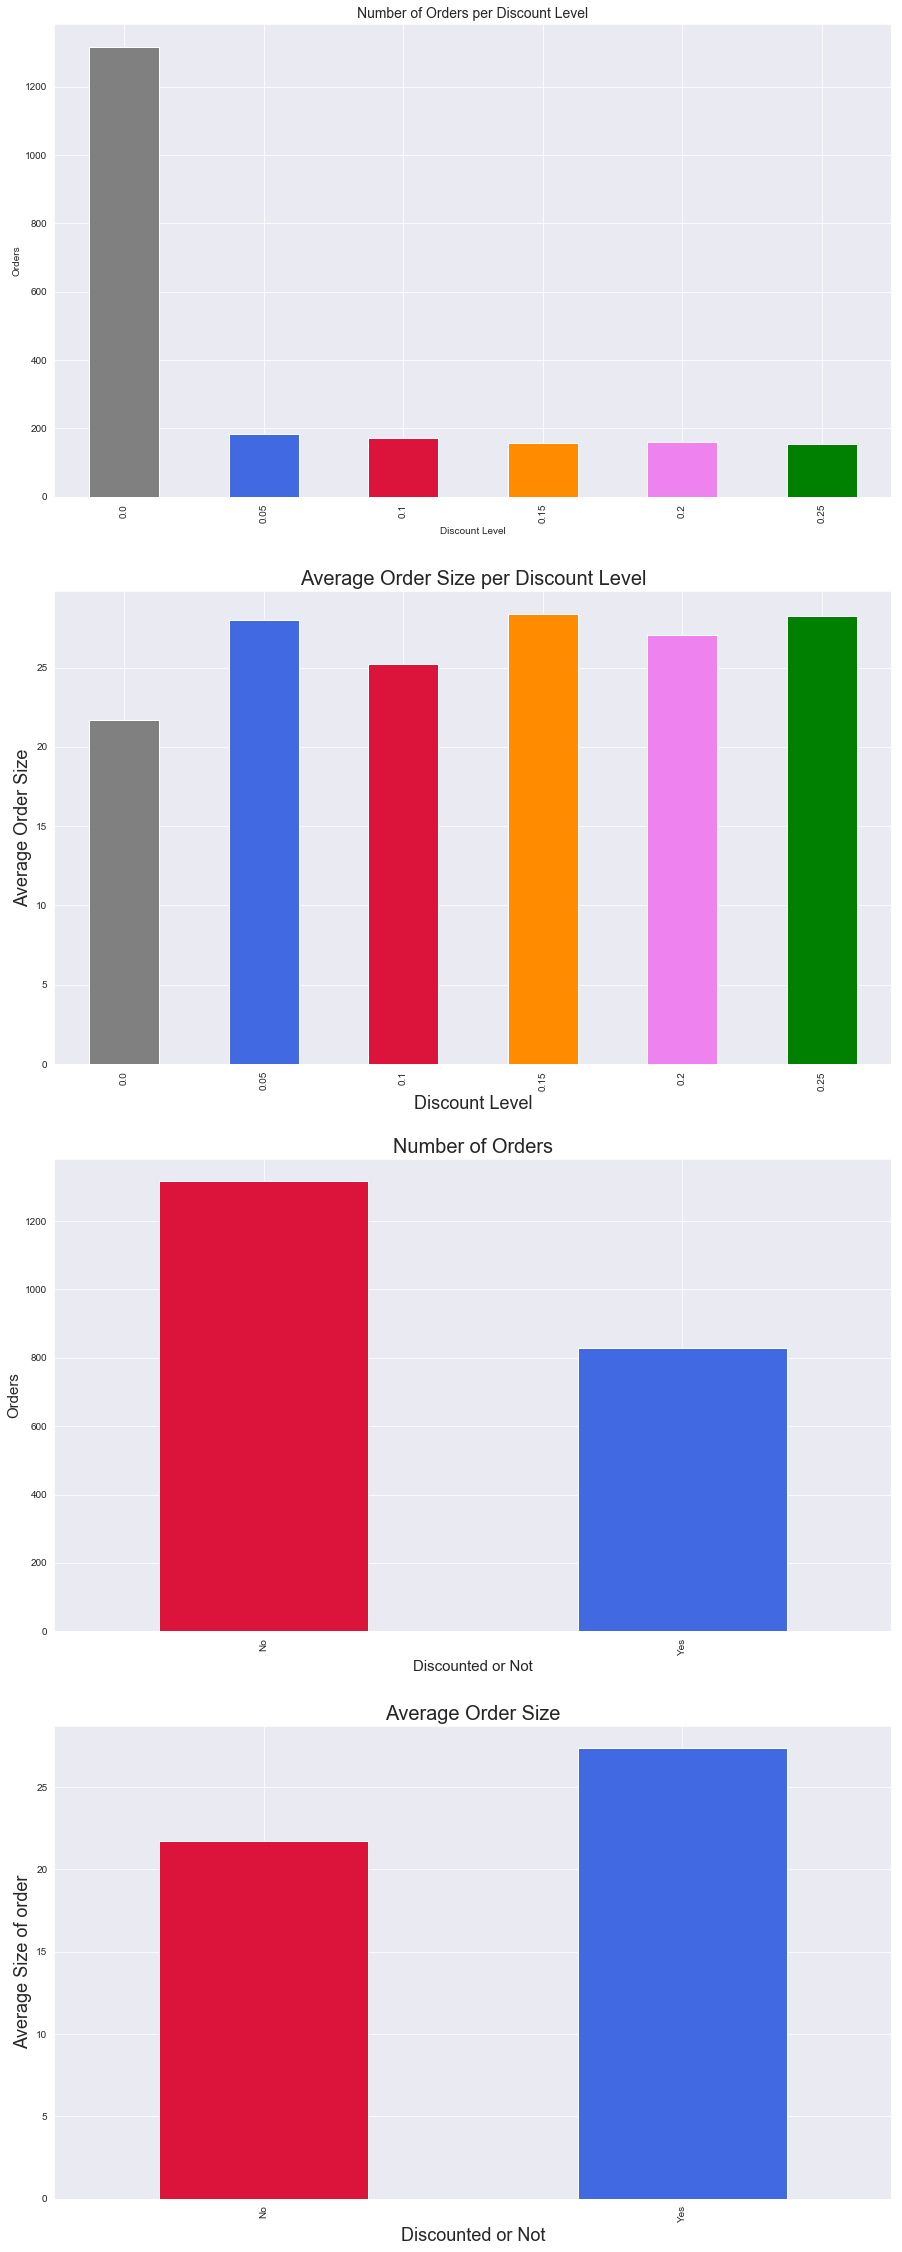

In [49]:
# Let's look at the sizes of orders with a discount and without a discount
fig, axes = plt.subplots(4, 1, figsize=(15, 40))
sns.set_style('darkgrid')

discounts.groupby(['Discount'])['Quantity'].count().plot(kind='bar', ax= axes[0], color=['grey', 'royalblue', 'crimson', 'darkorange','violet', 'green'])
discounts.groupby(['Discount'])['Quantity'].mean().plot(kind='bar', ax=axes[1], color=['grey', 'royalblue', 'crimson', 'darkorange', 'violet','green'])
discounts.groupby(['Discounted'])['Quantity'].count().plot(kind='bar', ax=axes[2], color=['crimson', 'royalblue'])
discounts.groupby(['Discounted'])['Quantity'].mean().plot(kind='bar', ax=axes[3], color=['crimson', 'royalblue'])
axes[0].set_title('Number of Orders per Discount Level', fontsize=14)
axes[0].set_xlabel('Discount Level')
axes[0].set_ylabel('Orders')

axes[1].set_title('Average Order Size per Discount Level', fontsize=20)
axes[1].set_xlabel('Discount Level', fontsize=18)
axes[1].set_ylabel('Average Order Size', fontsize=18)

axes[2].set_title('Number of Orders', fontsize=20)
axes[2].set_xlabel('Discounted or Not', fontsize=15)
axes[2].set_ylabel('Orders', fontsize=15)

axes[3].set_title('Average Order Size', fontsize=20)
axes[3].set_xlabel('Discounted or Not', fontsize=18)
axes[3].set_ylabel('Average Size of order', fontsize=18)


plt.show()



In [50]:
difference_order_size = discounts.groupby(['Discounted'])['Quantity'].count()[0]-discounts.groupby(['Discounted'])['Quantity'].count()[1]
difference_average_order = discounts.groupby(['Discounted'])['Quantity'].mean()[1]-discounts.groupby(['Discounted'])['Quantity'].mean()[0]
discount_mean = discounts.groupby(['Discounted'])['Quantity'].mean()[1]
non_discount_mean = discounts.groupby(['Discounted'])['Quantity'].mean()[0]
discount_std = discounts.groupby(['Discounted'])['Quantity'].std()[1]
non_discount_std = discounts.groupby(['Discounted'])['Quantity'].std()[0]
    
print("There were {} more orders made without a discount being applied.".format(difference_order_size))
print("The average difference between discounted orders and non-discounted orders was:", difference_average_order)

print('Discounted Orders Mean:', discount_mean)
print('Discounted Orders Standard Deviation: ', discount_std)
print('Non-Discounted Orders Mean:', non_discount_mean)
print('Non-Discounted Orders Standard Deviation: ', non_discount_std)

There were 487 more orders made without a discount being applied.
The average difference between discounted orders and non-discounted orders was: 5.638954908472158
Discounted Orders Mean: 27.35421686746988
Discounted Orders Standard Deviation:  20.72066677628295
Non-Discounted Orders Mean: 21.715261958997722
Non-Discounted Orders Standard Deviation:  17.507493472393033


We can see from these displays that while more orders come in that are not discounted.  The average size of orders given the different dicounts levels shows that orders with discounts tend to be larger than orders without.  But is this difference statistically significant?  That is what needs to be investigated further.

In order to test this we will need to run a hypothesis test using a two tailed t-test. It is two tailed because we want to see if having a discount makes a statistically significant difference on the order size.  For this test, we will first group together orders as discounted or not.  Before we run a t-test we need to check our assumptions.  A two sample t-test assumes that the data is normally distributed and the samples have equal variances.  We can assess this using a distribution plot.

In [51]:
# Separate the discounted and non-discounted order quantities
control = discounts[discounts['Discount']==0]['Quantity']
experimental = discounts[discounts['Discount']!=0]['Quantity']


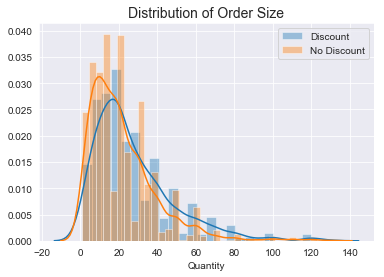

In [52]:
ax = sns.distplot(experimental, label = 'Discount')
ax = sns.distplot(control, label = 'No Discount')
ax.set_title('Distribution of Order Size', fontsize=14)
ax.legend()

In [53]:
# Checking the variances of the discounted orders and the non-discounted orders
print(np.var(control))
print(np.var(experimental))

306.2795924332757
428.8287472782697


The distribution plot is fairly normal with a positive skew and the variances are differing by about 100 so we should use a Welch's t-test instead of the student t-test.

In [54]:
# t-test and cohen's d
#result = stats.ttest_ind(experimental, control)
#ttest_result(result, 0.05)
# Welch's T-test
welch_test_results(experimental, control)

d = Cohen_d(experimental, control)
print("Cohen's D:", d)

P-value result for Welch's t-test 5.0256243611102036e-11
Cohen's D: 0.29970787209408895


In [55]:
a = experimental.mean()
b = control.mean()
print_results(a,b)

Average with discount: 27.35
Average without discount: 21.72
Effect Size: 5.64
Relative Effect Size: 0.26


With analyzing the t-test results, we can see that the results are statistically significant enough with a p-value of .00000000005025.  A Cohen's D value of .299 is said to be a small effect, which doesn't mean its trivial but difficult to see with the naked eye.  This tells us the difference in the means for discounted orders and non-discounted orders. There is less than 1 standard deviation between the means of discounted orders and non-discounted orders. Looking at the effect size we see the discounts increased the order size average to be 6 more than non-discounted orders. We can see from the relative effect size that this is a 26% increase in our orders sizes.  

Now that we know there is a difference in order sizes when a discount is applied, let's look at if there is a difference between the different discounts applied.

## Part 2:

H<sub>0</sub>: The average number of orders is the same regardless of the level of the discount.
H<sub>a</sub>: The average number of orders is not the same when the level of discount is different.

alpha: 0.05

In [56]:
# Review how many orders had discounts applied at different levels
discounts.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [57]:
discounts.head()

,ProductId,UnitPrice,Quantity,Discount,Discounted
0,11,14.0,12,0.0,No
1,42,9.8,10,0.0,No
2,72,34.8,5,0.0,No
3,14,18.6,9,0.0,No
4,51,42.4,40,0.0,No


In [58]:
# Let's create a new DataFrame without the non-discounted orders
discounted = discounts[['ProductId', 'UnitPrice', 'Quantity', 'Discount']].copy()
non_discounted_rows = discounted[discounted['Discount']==0.0].index
discounted.drop(non_discounted_rows, inplace=True)
discounted.head()

,ProductId,UnitPrice,Quantity,Discount
6,51,42.4,35,0.15
7,65,16.8,15,0.15
8,22,16.8,6,0.05
9,57,15.6,15,0.05
11,20,64.8,40,0.05


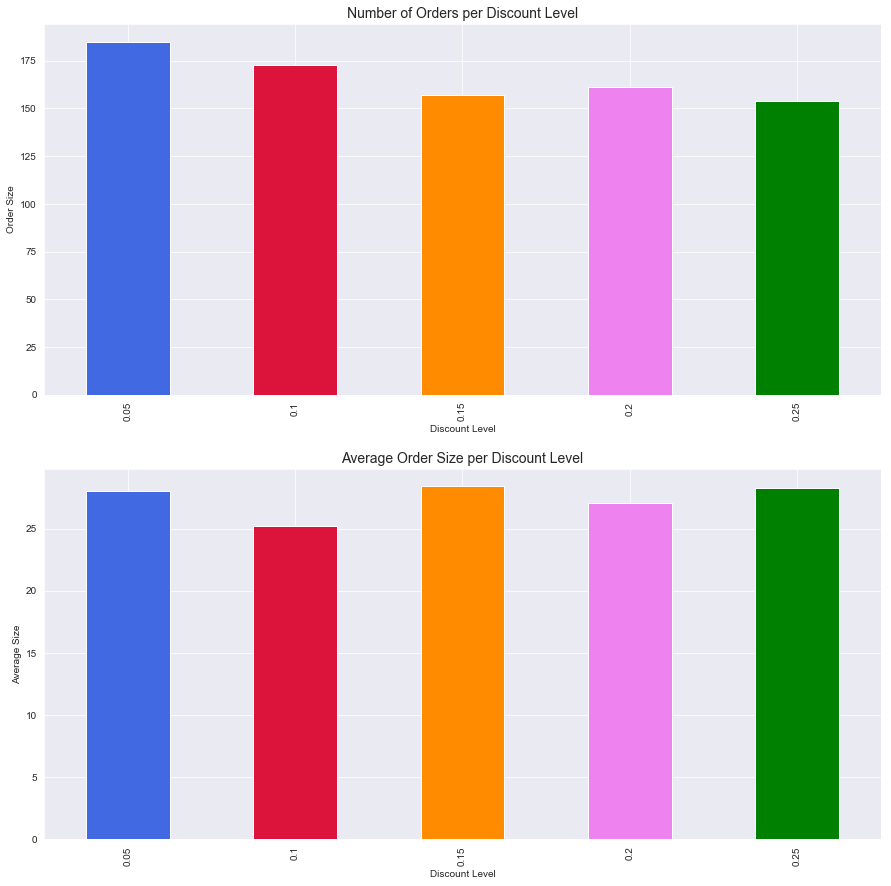

In [59]:
# Let's view the differences graphically again without the non-discounted orders
fig, axes = plt.subplots(2, 1, figsize=(15,15))

discounted.groupby(['Discount'])['Quantity'].count().plot(kind='bar', ax=axes[0], color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
discounted.groupby(['Discount'])['Quantity'].mean().plot(kind='bar', ax=axes[1], color=['royalblue', 'crimson', 'darkorange', 'violet','green'])

axes[0].set_title('Number of Orders per Discount Level', fontsize=14)
axes[0].set_xlabel('Discount Level')
axes[0].set_ylabel('Order Size')

axes[1].set_title('Average Order Size per Discount Level', fontsize=14)
axes[1].set_xlabel('Discount Level')
axes[1].set_ylabel('Average Size')
plt.show()

Looking at these bar graphs it seems the differences between each discount level is very slight.
So let's see if it is significant.  Since we are comparing multiple categories, using an ANOVA test would be the most useful.  

In [60]:
# Before performing ANOVA we need to generate a linear model
linear_model = ols('Quantity ~ C(Discount)', discounted).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6741
Date:                Tue, 21 Apr 2020   Prob (F-statistic):              0.610
Time:                        20:33:54   Log-Likelihood:                -3691.7
No. Observations:                 830   AIC:                             7393.
Df Residuals:                     825   BIC:                             7417.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              28.0108      1.525     18.372      0.000      25.018      31.003
C(Discount)[T.0.1]     -2.7738      2.193     -1.265      0.206      -7.079       1.531
C(Discount)[T.0.15]     0.3714      2.250      0.165      0.869      -4.045       4.788
C(Discount)[T.0.2]     -0.9860      2.235     -0.441      0.659      -5.373       3.401
C(Discount)[T.0.25]     0.2294      2.262      0.101      0.919      -4.211       4.669
==============================================================================
Omnibus:                      263.705   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              751.622
Skew:                           1.598   Prob(JB):                    6.13e-164
Kurtosis:                       6.394   Cond. No.                         5.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
sm.stats.anova_lm(linear_model, typ = 2)


,sum_sq,df,F,PR(>F)
C(Discount),1159.517551,4.0,0.674103,0.610041
Residual,354768.342690,825.0,NaN,NaN


In [62]:
mc = MultiComparison(discounted['Quantity'], discounted['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  0.05    0.1  -2.7738 0.6877 -8.7696  3.222  False
  0.05   0.15   0.3714    0.9 -5.7803  6.523  False
  0.05    0.2   -0.986    0.9 -7.0962 5.1242  False
  0.05   0.25   0.2294    0.9 -5.9546 6.4134  False
   0.1   0.15   3.1452 0.6246 -3.1037  9.394  False
   0.1    0.2   1.7879    0.9 -4.4202 7.9959  False
   0.1   0.25   3.0033 0.6636 -3.2774 9.2839  False
  0.15    0.2  -1.3573    0.9  -7.716 5.0014  False
  0.15   0.25  -0.1419    0.9 -6.5715 6.2877  False
   0.2   0.25   1.2154    0.9 -5.1745 7.6054  False
---------------------------------------------------
[0.05 0.1  0.15 0.2  0.25]


Looking at the results of the ANOVA table, we can see that the p-value is 0.61041 which is larger than the alpha that we set of 0.05.  Therefore we fail to reject the null hypothesis and that none of the discount levels are statistically significant of a difference from each other. We can also check our linear model and see that the r-squared value of 0.003 tells us that the discount levels are not explaining the difference in the quantity of products customers order. 

So the answer to our first question is that discounts do influence customers to order a higher quantity of items, however there isn't a significant difference in the discount levels impact on the quantity of the orders.  

Well, this is good information, however does offering a discount actually payoff.  We know that customers increase the quantity they order, but does that actually increase our revenue?

## Question 2

## Do discounts have a statistically significant impact on the revenue produced for a given order?  If so, what level(s) of discount increase revenue?

H<sub>0</sub>: The average revenue is the same for orders with or without discounts.

H<sub>a</sub>: The average revenue is not the same for orders with or without discounts.

alpha = 0.05

### Part 1:
We will first investigate if there is a statistical significant difference between the impact of discounts on the revenue from orders.  

In [63]:
cur.execute("""SELECT od.OrderId, od.UnitPrice, od.Discount, od.Quantity,
                SUM(od.Quantity * od.UnitPrice * (1-od.Discount)) OrderRevenue
                FROM OrderDetail od
                INNER JOIN Product p on od.ProductId = p.Id
                GROUP BY od.OrderId""")
discounts_revenue = pd.DataFrame(cur.fetchall())
discounts_revenue.columns = [column[0] for column in cur.description]
print(len(discounts_revenue))
discounts_revenue.head()

830


,OrderId,UnitPrice,Discount,Quantity,OrderRevenue
0,10248,14.0,0.00,12,440.00
1,10249,18.6,0.00,9,1863.40
2,10250,7.7,0.00,10,1552.60
3,10251,16.8,0.05,6,654.06
4,10252,64.8,0.05,40,3597.90


In [64]:
discounts_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 5 columns):
OrderId         830 non-null int64
UnitPrice       830 non-null float64
Discount        830 non-null float64
Quantity        830 non-null int64
OrderRevenue    830 non-null float64
dtypes: float64(3), int64(2)
memory usage: 32.5 KB


In [65]:
# identifying which orders have a discount
discounts_revenue['Discounted'] = discounts_revenue['Discount'].apply(lambda x: 'No' if x==0 else 'Yes')
discounts_revenue.head()

,OrderId,UnitPrice,Discount,Quantity,OrderRevenue,Discounted
0,10248,14.0,0.00,12,440.00,No
1,10249,18.6,0.00,9,1863.40,No
2,10250,7.7,0.00,10,1552.60,No
3,10251,16.8,0.05,6,654.06,Yes
4,10252,64.8,0.05,40,3597.90,Yes


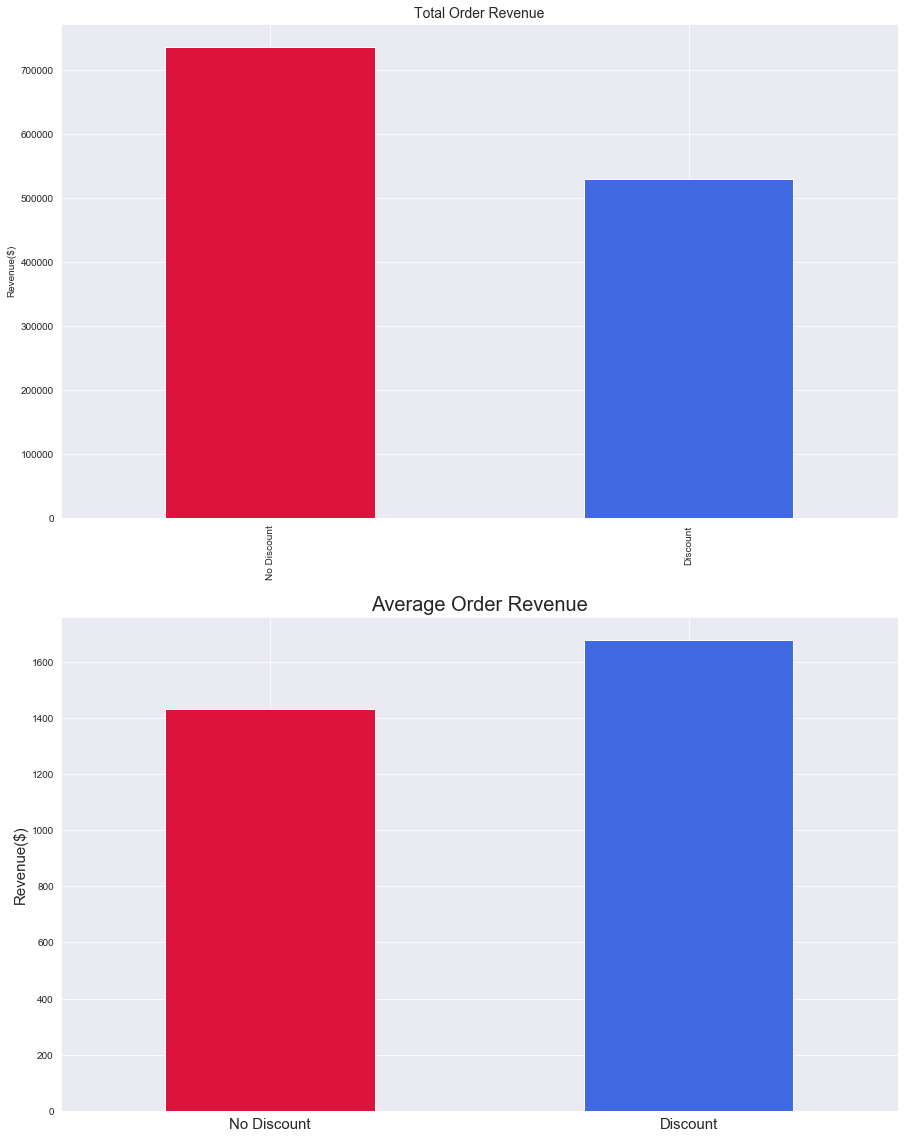

In [66]:
fig, axes = plt.subplots(2, 1, figsize = (15,20))
discounts_revenue.groupby(['Discounted'])['OrderRevenue'].sum().plot(kind='bar', ax=axes[0], color=['crimson', 'royalblue'])
discounts_revenue.groupby(['Discounted'])['OrderRevenue'].mean().plot(kind='bar', ax=axes[1], color=['crimson', 'royalblue'])

axes[0].set_title('Total Order Revenue', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Revenue($)')
axes[0].set_xticklabels(['No Discount', 'Discount'])

axes[1].set_title('Average Order Revenue', fontsize=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Revenue($)', fontsize=15)
axes[1].set_xticklabels(['No Discount', 'Discount'], rotation='horizontal', fontsize=15)


plt.show()


In [67]:
discounts_revenue.groupby(['Discounted'])['OrderRevenue'].mean()

Discounted
No     1431.988123
Yes    1676.427672
Name: OrderRevenue, dtype: float64

It makes sense that earlier we saw that there were more orders without discounts so it makes sense that more money would be earned by non-discounted orders.  However the average order cost is higher for discounted items.  So we should investigate if this is statistically significant and see if discounts increase the average revenue per order.
To test the hypothesis, we should use a two sample tailed t-test.  We should check our assumptions to see if it is normally distributed and if the variances are equal.

In [68]:
# separating the dataframe between discounted and non-discounted items:
discounted_item_price = discounts_revenue[discounts_revenue['Discount'] != 0]['OrderRevenue']
not_discounted_item_price = discounts_revenue[discounts_revenue['Discount']==0]['OrderRevenue']


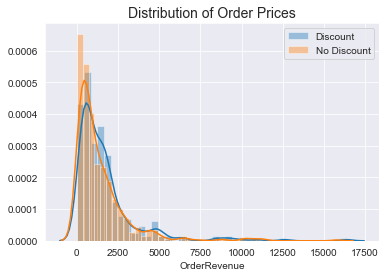

In [69]:
ax = sns.distplot(discounted_item_price, label = 'Discount')
ax = sns.distplot(not_discounted_item_price, label = 'No Discount')
ax.set_title('Distribution of Order Prices', fontsize=14)
ax.legend()

Since the data is not normal we can use a Mann-Whitney U test to see if the discounted and non-discounted orders are the same.

In [70]:
mannwhitneyu(discounted_item_price, not_discounted_item_price)

MannwhitneyuResult(statistic=71368.0, pvalue=0.0016675004338841232)

From the Mann Whitney U result we see that p is less than alpha so there is a significant difference in mean revenue.  

In [34]:
# Checking the variances of the discounted orders and the non-discounted orders
print(np.var(discounted_item_price))
print(np.var(not_discounted_item_price))

3790411.6100976598
3138171.7881153408


Looking at the graph it is strongly positively skewed.  Perhaps a t-test isn't the best option.

In [35]:
# Log transforming order price to see if it will be more normalized for the t-test
discounted_log = discounts_revenue.copy()
discounted_log['LogRevenue'] = np.log(discounts_revenue['OrderRevenue'])
discount_log = discounted_log[discounted_log['Discounted']=='Yes']
no_discount_log = discounted_log[discounted_log['Discounted']=='No']
print(no_discount_log.head())

   OrderId  UnitPrice  Discount  Quantity  OrderRevenue Discounted  LogRevenue
0    10248       14.0       0.0        12         440.0         No    6.086775
1    10249       18.6       0.0         9        1863.4         No    7.530158
2    10250        7.7       0.0        10        1552.6         No    7.347686
5    10253       10.0       0.0        20        1444.8         No    7.275726
7    10255       15.2       0.0        20        2490.5         No    7.820239


Text(0.5,1,'Revenue Log Transformed')

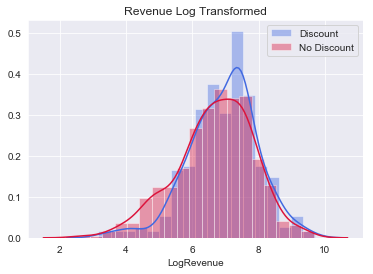

In [36]:
sns.distplot(discount_log.LogRevenue, color='royalblue', label='Discount')
sns.distplot(no_discount_log.LogRevenue, color='crimson', label='No Discount')
plt.legend()
plt.title("Revenue Log Transformed")

In [37]:
print(np.var(discount_log.LogRevenue))
print(np.var(no_discount_log.LogRevenue))

1.0949676688856071
1.380356342797225


We can see with that log transformation that our data is more normally distributed.  So let's use the transformed data to run our ttest and calculate Cohen's d and the variance's are more similar so we can perform a student t-test.

In [38]:
# t-test and cohen's d
result = stats.ttest_ind(discount_log.LogRevenue, no_discount_log.LogRevenue)
ttest_result(result, 0.05)

d = Cohen_d(discount_log.LogRevenue, no_discount_log.LogRevenue)
print("Cohen's D:", d)

Reject the null hypothesis. 
 Results are statistically significant with a p-value = 0.0013692485593129766
Cohen's D: 0.2296138210535798


In [39]:
a = discounted_item_price.mean()
b = not_discounted_item_price.mean() 
print_results(a,b)

Average with discount: 1676.43
Average without discount: 1431.99
Effect Size: 244.44
Relative Effect Size: 0.17


Because the resulting p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in the average cost per order between discounted and non-discounted orders.  The effect size informs us that difference is about $245 which is a 17% increase.

### Part 2:
Since we concluded there is a statistically significant difference between discounted orders and non-discounted orders the next step is to test which level of discount is causing more of an increase if it exists.

H<sub>0</sub>: The order price is the same regardless of the level of discount.

H<sub>a</sub>: The order price is not the same at different levels of discount.

alpha = 0.05

Since we are comparing multiple features at once, a t-test wouldn't work because of multiple comparisons and instead we should use ANOVA.

In [40]:
# Dropping the entries for non-discounted orders
discounts_revenue = discounts_revenue[discounts_revenue.Discount != 0.0]

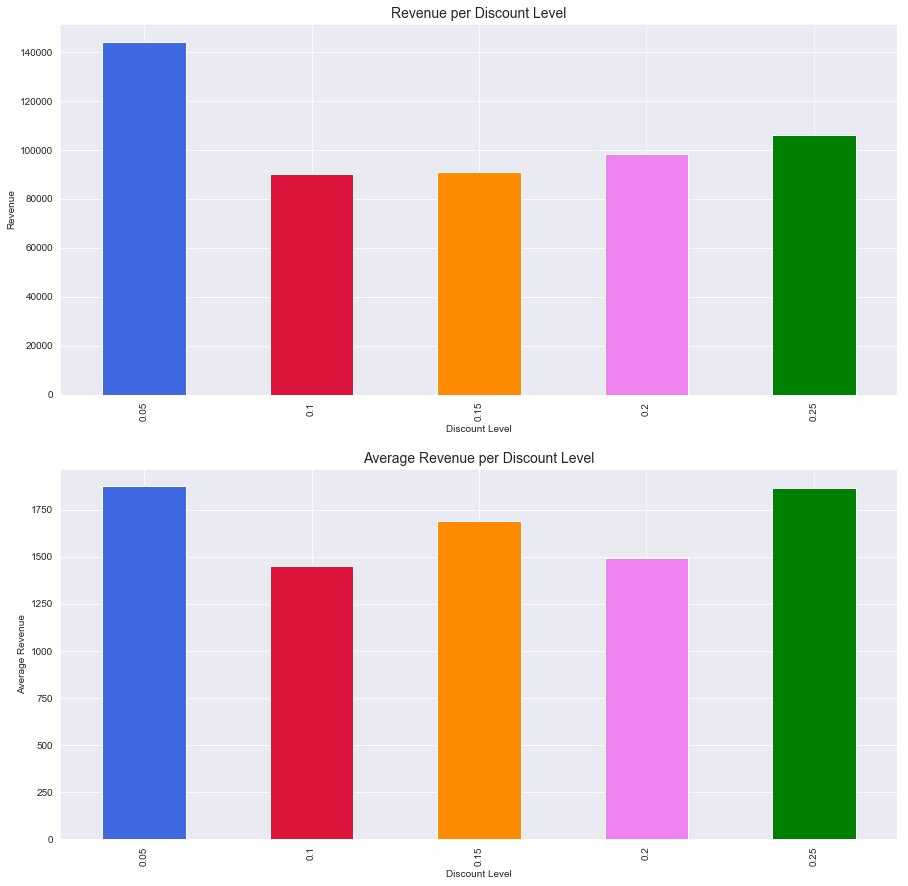

In [41]:
# Let's compare the means visually first
fig, axes = plt.subplots(2, 1, figsize=(15,15))

discounts_revenue.groupby(['Discount'])['OrderRevenue'].sum().plot(kind='bar', ax=axes[0], color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
discounts_revenue.groupby(['Discount'])['OrderRevenue'].mean().plot(kind='bar', ax=axes[1], color=['royalblue', 'crimson', 'darkorange', 'violet','green'])

axes[0].set_title('Revenue per Discount Level', fontsize=14)
axes[0].set_xlabel('Discount Level')
axes[0].set_ylabel('Revenue')

axes[1].set_title('Average Revenue per Discount Level', fontsize=14)
axes[1].set_xlabel('Discount Level')
axes[1].set_ylabel('Average Revenue')
plt.show()

In [42]:
# Before performing ANOVA we need to fit a linear model
formula2 = 'OrderRevenue ~ C(Discount)'
linear_model2 = ols(formula2, discounts_revenue).fit()
linear_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           OrderRevenue   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6774
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.608
Time:                        17:39:59   Log-Likelihood:                -2840.4
No. Observations:                 316   AIC:                             5691.
Df Residuals:                     311   BIC:                             5710.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1872.4499    222.678      8.409      0.000    1434.304    2310.596
C(Discount)[T.0.1]   -421.1493    333.418     -1.263      0.207   -1077.190     234.891
C(Discount)[T.0.15]  -185.7763    346.830     -0.536      0.593    -868.206     496.653
C(Discount)[T.0.2]   -381.7965    327.773     -1.165      0.245   -1026.730     263.137
C(Discount)[T.0.25]   -10.5489    341.423     -0.031      0.975    -682.340     661.242
==============================================================================
Omnibus:                      257.135   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3886.484
Skew:                           3.358   Prob(JB):                         0.00
Kurtosis:                      18.813   Cond. No.                         5.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
sm.stats.anova_lm(linear_model2, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),1.034529e+07,4.0,0.677387,0.608083
Residual,1.187425e+09,311.0,NaN,NaN


In [44]:
mc = MultiComparison(discounts_revenue['OrderRevenue'], discounts_revenue['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff p-adj    lower      upper   reject
----------------------------------------------------------
  0.05    0.1 -421.1493 0.6888  -1336.011  493.7124  False
  0.05   0.15 -185.7763    0.9 -1137.4381  765.8856  False
  0.05    0.2 -381.7965 0.7444 -1281.1697  517.5767  False
  0.05   0.25  -10.5489    0.9  -947.3747  926.2769  False
   0.1   0.15   235.373    0.9  -762.6154 1233.3615  False
   0.1    0.2   39.3528    0.9   -908.905  987.6105  False
   0.1   0.25  410.6004 0.7555  -573.2508 1394.4517  False
  0.15    0.2 -196.0203    0.9 -1179.8298  787.7893  False
  0.15   0.25  175.2274    0.9  -842.9335 1193.3883  False
   0.2   0.25  371.2477 0.8089  -598.2179 1340.7132  False
----------------------------------------------------------
[0.05 0.1  0.15 0.2  0.25]


The ANOVA table gives us a p-value of 0.608 which is greater than 0.05, so we fail to reject the null hypothesis and there is not statistically significant evidence that a certain discount changes the order price more than other discounts.  When checking the linear model, we also see that that r-squared value is very small 0.09.  The only result that might be worth investigating more is the discount level of 0.05 as it has a p-value that is close to 0.05 at 0.051.  This isn't enough alone to sway the results of the test but something to take note of and so let's compare the average order price of non-discounted orders to ones with 5% discount.


In [45]:
five_percent_average = round((discounts_revenue.loc[discounts_revenue.Discount ==0.05]).OrderRevenue.mean(),2)
ten_percent_average = round((discounts_revenue.loc[discounts_revenue.Discount ==0.10]).OrderRevenue.mean(),2)
fifteen_percent_average = round((discounts_revenue.loc[discounts_revenue.Discount ==0.15]).OrderRevenue.mean(),2)
twenty_percent_average = round((discounts_revenue.loc[discounts_revenue.Discount ==0.20]).OrderRevenue.mean(),2)
twenty_five_percent_average = round((discounts_revenue.loc[discounts_revenue.Discount ==0.25]).OrderRevenue.mean(),2)

In [46]:
print("Average revenue for 5% discount: ", five_percent_average)
print("Average revenue for 10% discount: ", ten_percent_average)
print("Average revenue for 15% discount: ", fifteen_percent_average)
print("Average revenue for 20% discount: ", twenty_percent_average)
print("Average revenue for 25% discount: ", twenty_five_percent_average)

Average revenue for 5% discount:  1872.45
Average revenue for 10% discount:  1451.3
Average revenue for 15% discount:  1686.67
Average revenue for 20% discount:  1490.65
Average revenue for 25% discount:  1861.9


So for our second question we can conclude that discounts increase the average revenue per order but the level of discount that is most effective is not clear.  Judging from these outcomes it seems that the 5% discount and the 25% discount see a higher average revenue. But that isn't necessarily statistically significant.

## Question 3

## Do discounts generate revenue in certain regions more than others?

To investigate this question we need to look at the revenue generated in different regions and then compare which regions utilize discounts more.  Finally then we should see if discounts explain the region with a higher revenue.
H<sub>0</sub>: Revenue is the same regardless of region.
H<sub>a</sub>: Revenue is higher some regions more than others.


In [47]:
cur.execute("""SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Quantity, od.Discount, 
(od.Quantity * od.UnitPrice * (1-od.Discount)) Revenue FROM Customer c 
JOIN [Order] o ON c.Id=o.CustomerId
JOIN OrderDetail od ON od.OrderId=o.Id""")
customer_region = pd.DataFrame(cur.fetchall())
customer_region.columns = [column[0] for column in cur.description]
customer_region.head()

,Region,OrderId,Quantity,UnitPrice,Quantity,Discount,Revenue
0,Western Europe,10248,12,14.0,12,0.0,168.0
1,Western Europe,10248,10,9.8,10,0.0,98.0
2,Western Europe,10248,5,34.8,5,0.0,174.0
3,Western Europe,10249,9,18.6,9,0.0,167.4
4,Western Europe,10249,40,42.4,40,0.0,1696.0


In [48]:
customer_region.Region.value_counts()

Western Europe     736
North America      427
South America      304
British Isles      190
Northern Europe    143
Southern Europe    137
Scandinavia         70
Central America     55
Eastern Europe      16
Name: Region, dtype: int64

In [49]:
customer_region = customer_region.groupby(['Region', 'OrderId', 'Discount'])['Revenue'].sum().reset_index()
customer_region.head()

,Region,OrderId,Discount,Revenue
0,British Isles,10289,0.00,479.4
1,British Isles,10298,0.00,1199.0
2,British Isles,10298,0.25,1446.0
3,British Isles,10309,0.00,1762.0
4,British Isles,10315,0.00,516.8


In [50]:
customer_region.groupby('Region').count()

,OrderId,Discount,Revenue
Region,,,
British Isles,88,88,88
Central America,21,21,21
Eastern Europe,7,7,7
North America,191,191,191
Northern Europe,70,70,70
Scandinavia,32,32,32
South America,149,149,149
Southern Europe,74,74,74
Western Europe,333,333,333


Because some regions have a smaller amount of orders, it makes sense to combine these regions in order to have sizes that meet the criteria of a minimum sample size of 30. To use the ANOVA test we will need to fulfill the assumption of equal variances.

In [51]:
#Combining Eastern and Southern Europe:
customer_region.loc[(customer_region.Region == 'Eastern Europe') |(customer_region.Region == 'Southern Europe'), 'Region'] = 'Southern and Eastern Europe'

#Combining Scandinavia and Northern Europe:
customer_region.loc[(customer_region.Region == 'Scandinavia')|(customer_region.Region == 'Northern Europe'), 'Region'] = 'Scandinavia and Northern Europe'

#Combining Central and South America
customer_region.loc[(customer_region.Region == 'Central America')|(customer_region.Region == 'South America'), 'Region'] = 'Central and South America'

In [52]:
customer_region.groupby('Region').count()

,OrderId,Discount,Revenue
Region,,,
British Isles,88,88,88
Central and South America,170,170,170
North America,191,191,191
Scandinavia and Northern Europe,102,102,102
Southern and Eastern Europe,81,81,81
Western Europe,333,333,333


In [53]:
customer_region.head(10)

,Region,OrderId,Discount,Revenue
0,British Isles,10289,0.00,479.40
1,British Isles,10298,0.00,1199.00
2,British Isles,10298,0.25,1446.00
3,British Isles,10309,0.00,1762.00
4,British Isles,10315,0.00,516.80
5,British Isles,10318,0.00,240.40
6,British Isles,10321,0.00,144.00
7,British Isles,10335,0.20,2036.16
8,British Isles,10355,0.00,480.00
9,British Isles,10359,0.05,3471.68


In [54]:
customer_region.dtypes

Region       object
OrderId       int64
Discount    float64
Revenue     float64
dtype: object

In [55]:
customer_region.head(89)

,Region,OrderId,Discount,Revenue
0,British Isles,10289,0.00,479.40
1,British Isles,10298,0.00,1199.00
2,British Isles,10298,0.25,1446.00
3,British Isles,10309,0.00,1762.00
4,British Isles,10315,0.00,516.80
...,...,...,...,...
84,British Isles,11056,0.00,3740.00
85,British Isles,11057,0.00,45.00
86,British Isles,11063,0.00,420.00
87,British Isles,11063,0.10,922.95


In [56]:
customer_region['Revenue']=pd.to_numeric(customer_region.Revenue)
customer_region.dtypes

Region       object
OrderId       int64
Discount    float64
Revenue     float64
dtype: object

In [57]:
customer_region.groupby('Region').count()

,OrderId,Discount,Revenue
Region,,,
British Isles,88,88,88
Central and South America,170,170,170
North America,191,191,191
Scandinavia and Northern Europe,102,102,102
Southern and Eastern Europe,81,81,81
Western Europe,333,333,333


Now our sample sizes are all large enough to meet that criteria.  Next we will look at displays to see what varies from region to region.

Text(0,0.5,'')

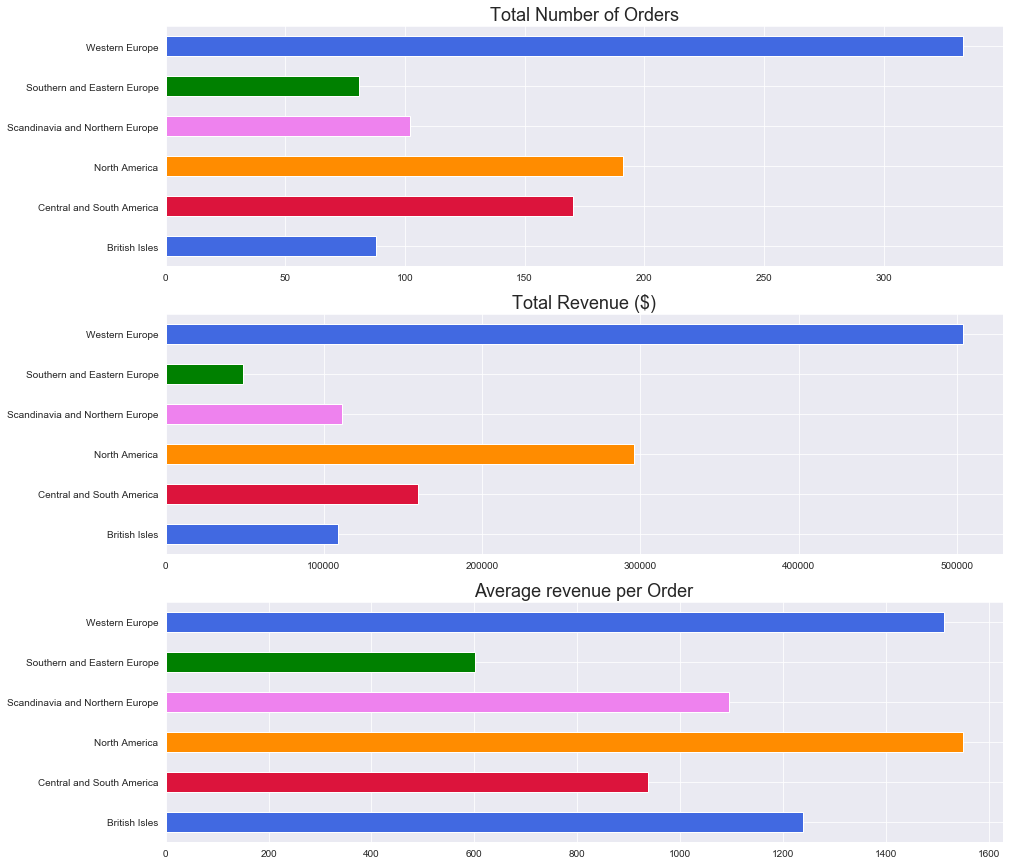

In [58]:
# Visualizing number of orders, total revenue per order and average revenue per order for each region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
customer_region.groupby(['Region'])['Revenue'].count().plot(kind = 'barh', ax = ax1, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
customer_region.groupby(['Region'])['Revenue'].sum().plot(kind = 'barh', ax = ax2,color=['royalblue', 'crimson', 'darkorange', 'violet','green'] )
customer_region.groupby(['Region'])['Revenue'].mean().plot(kind = 'barh', ax = ax3, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
ax1.set_title('Total Number of Orders', fontsize=18)
ax1.set_ylabel('')
ax2.set_title('Total Revenue ($)', fontsize=18)
ax2.set_ylabel('')
ax3.set_title('Average revenue per Order', fontsize=18)
ax3.set_ylabel('')


Comparing the three graphs, we can see that while more orders come in from Western Europe which leads to more revenue coming from that region, the average revenue per order is slightly higher in North America.  So the first comparison is to see if there's a statistically significant difference between the revenue in each region and then we will look at discounts used in each region.

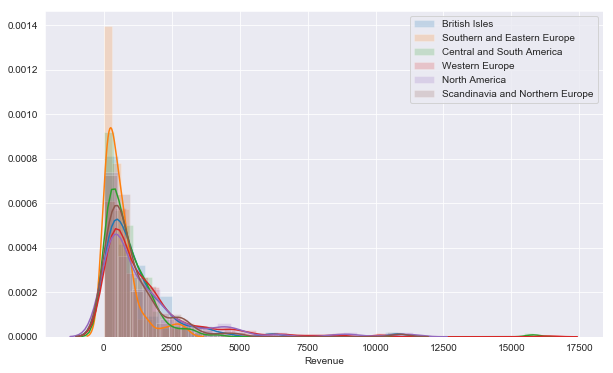

In [59]:
plt.figure(figsize=(10,6))
for region in set(customer_region.Region):
    region_group = customer_region.loc[customer_region['Region'] == region]
    sns.distplot(region_group['Revenue'], hist_kws=dict(alpha=0.2), label=region)
    plt.legend()

We can see from this display plot that all of these are positively skewed.  In order to perform an ANOVA test, the data should be normally distributed.  

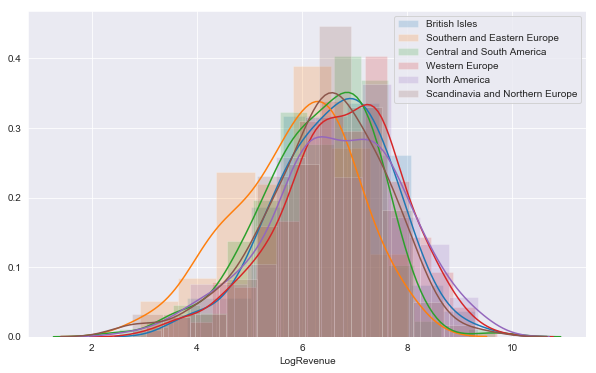

In [60]:
customer_region_log = customer_region.copy()
customer_region_log['LogRevenue'] = np.log(customer_region['Revenue'])
plt.figure(figsize=(10,6))
for region in set(customer_region_log.Region):
    region_group = customer_region_log.loc[customer_region_log['Region']==region]
    sns.distplot(region_group['LogRevenue'], hist_kws=dict(alpha=0.2), label=region)
    plt.legend()

With the log transformed data it now is normal so we can perform an ANOVA test to see if there's a significant differenct between revenue and the different regions.

In [61]:
linear_model3 = ols('LogRevenue ~ C(Region)', customer_region_log).fit()
linear_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LogRevenue   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     9.143
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           1.65e-08
Time:                        17:40:02   Log-Likelihood:                -1516.2
No. Observations:                 965   AIC:                             3044.
Df Residuals:                     959   BIC:                             3074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        6.6000      0.125     53.005      0.000       6.356       6.844
C(Region)[T.Central and South America]          -0.2889      0.153     -1.884      0.060      -0.590       0.012
C(Region)[T.North America]                       0.0540      0.150      0.359      0.720      -0.241       0.349
C(Region)[T.Scandinavia and Northern Europe]    -0.1742      0.170     -1.025      0.306      -0.508       0.159
C(Region)[T.Southern and Eastern Europe]        -0.7366      0.180     -4.095      0.000      -1.090      -0.384
C(Region)[T.Western Europe]                      0.1334      0.140      0.953      0.341      -0.141       0.408
==============================================================================
Omnibus:                       28.520   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.270
Skew:                          -0.422   Prob(JB):                     2.67e-07
Kurtosis:                       3.205   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
sm.stats.anova_lm(linear_model3, typ=2)

,sum_sq,df,F,PR(>F)
C(Region),62.372307,5.0,9.143024,1.647475e-08
Residual,1308.430172,959.0,NaN,NaN


In [63]:
mc = MultiComparison(customer_region_log['LogRevenue'], customer_region_log['Region'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
             group1                          group2             meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------
                  British Isles       Central and South America  -0.2889 0.4148 -0.7269  0.1491  False
                  British Isles                   North America    0.054    0.9 -0.3757  0.4837  False
                  British Isles Scandinavia and Northern Europe  -0.1742    0.9 -0.6595  0.3111  False
                  British Isles     Southern and Eastern Europe  -0.7366  0.001 -1.2501  -0.223   True
                  British Isles                  Western Europe   0.1334    0.9 -0.2664  0.5332  False
      Central and South America                   North America    0.343 0.0609 -0.0087  0.6946  False
      Central and South America Scandinavia and Northern Europe   0.1147 

The P-value from the ANOVA test is < 0.05, we can reject the null hypothesis and conclude there is a significant difference between each region and their revenues.  Using the Tukey multicomparison we can see that the significant differences exist between British Isles and Southern and Eastern Europe, Central and South America and Western Europe, North America and Scandinavia and Northern Europe, Scandinavia and Northern Europe and Southern and Eastern Europe, and Southern and Eastern Europe and Western Europe.  n

Part 2:
Now that we can see there is a difference between regions, we should look to identify discounts used in different regions and if they impacted the revenue.

In [64]:
# Creating DataFrames for each region
western_europe = customer_region[customer_region.Region == 'Western Europe']
central_south_america = customer_region[customer_region.Region == 'Central and South America']
north_america = customer_region[customer_region.Region == 'North America']
scandinavia_northern_europe = customer_region[customer_region.Region == 'Scandinavia and Northern Europe']
south_eastern_europe = customer_region[customer_region.Region == 'Southern and Eastern Europe']
british_isles = customer_region[customer_region.Region == 'British Isles']

In [65]:
western_europe.dtypes

Region       object
OrderId       int64
Discount    float64
Revenue     float64
dtype: object

In [66]:
print(len(western_europe))
western_europe.head()

333


,Region,OrderId,Discount,Revenue
632,Western Europe,10248,0.00,440.00
633,Western Europe,10249,0.00,1863.40
634,Western Europe,10251,0.00,336.00
635,Western Europe,10251,0.05,318.06
636,Western Europe,10252,0.00,1088.00


Text(0,0.5,'Average Revenue')

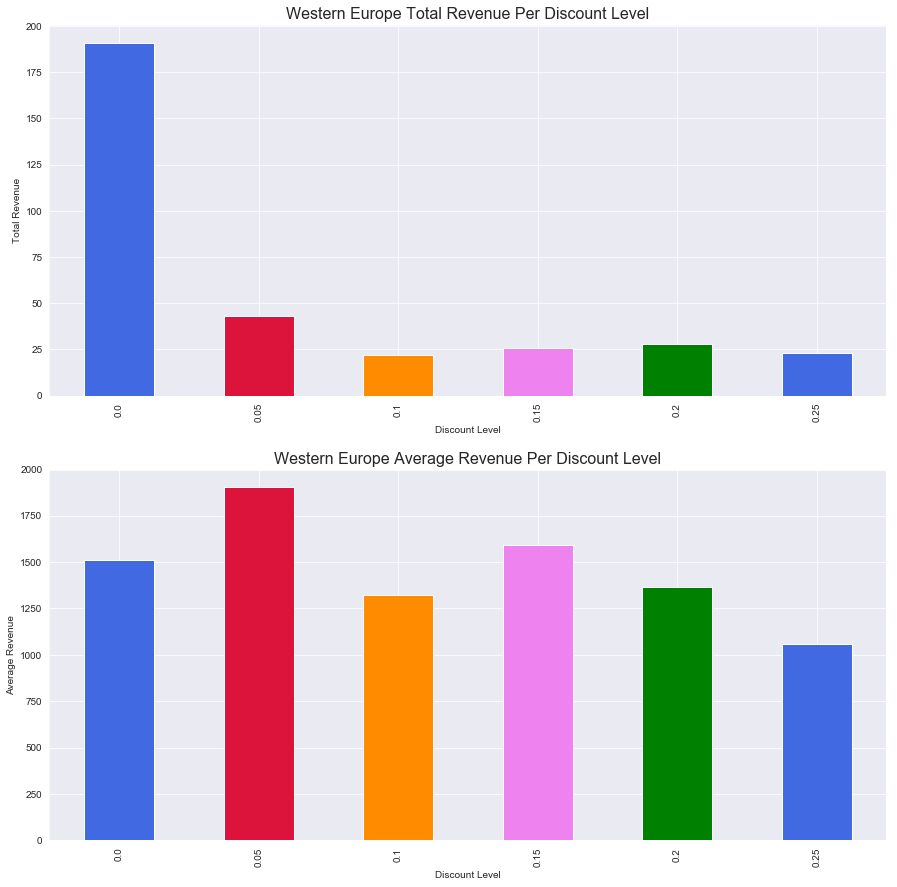

In [67]:
# Visually comparing discounts levels for Western Europe
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
western_europe.groupby(['Discount'])['Revenue'].count().plot(kind='bar', ax=ax1, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
western_europe.groupby(['Discount'])['Revenue'].mean().plot(kind='bar', ax=ax2, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])

ax1.set_title('Western Europe Total Revenue Per Discount Level', fontsize=16)
ax1.set_xlabel('Discount Level')
ax1.set_ylabel('Total Revenue')

ax2.set_title('Western Europe Average Revenue Per Discount Level', fontsize=16)
ax2.set_xlabel('Discount Level')
ax2.set_ylabel('Average Revenue')

## Western Europe Discount Check

We can see that even though more orders are made without a discount, the average revenue per order given the discount is higher at the 0.05 and 0.15 levels.  To see if this is actually significant we should run a hypothesis test.

H<sub>0</sub>: For Western Europe orders, the average revenue per order is the same regardless of discount level.

H<sub>a</sub>: For Western Europe orders, the average revenue is different for some discount levels. 

In [68]:
# First we should check if there's a significant difference between discounted and non-discounted orders in Western Europe
western_europe_discount = western_europe[western_europe['Discount'] != 0.0]
western_europe_nondiscount = western_europe[western_europe['Discount'] == 0.0]


Text(0.5,1,'Western Europe Revenue')

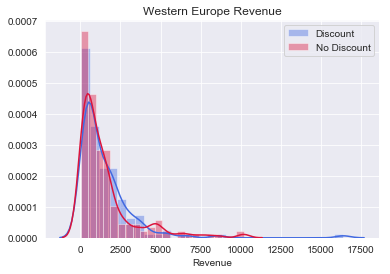

In [69]:
#Checking for normality
sns.distplot(western_europe_discount.Revenue, color='royalblue', label='Discount')
sns.distplot(western_europe_nondiscount.Revenue, color='crimson', label='No Discount')
plt.legend()
plt.title('Western Europe Revenue')

These are both positively skewed so we cannot assume normality.

In [70]:
# Checking variance
print(np.var(western_europe_discount.Revenue))
print(np.var(western_europe_nondiscount.Revenue))

3429710.403982176
3324665.762900858


In [71]:
# Log transform the data so that it is normal to be able to run a ttest
western_europe_discount_log = western_europe_discount.copy()
western_europe_discount_log['LogRevenue'] = np.log(western_europe_discount['Revenue'])
western_europe_nondiscount_log = western_europe_nondiscount.copy()
western_europe_nondiscount_log['LogRevenue'] = np.log(western_europe_nondiscount['Revenue'])
print(len(western_europe_discount_log))
print(len(western_europe_nondiscount_log))

142
191


Text(0.5,1,'Western Europe Revenue Log Transformed')

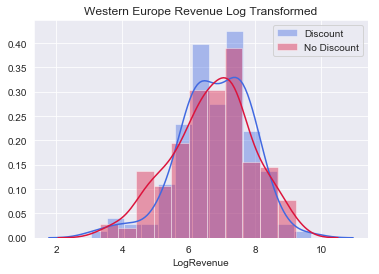

In [72]:
sns.distplot(western_europe_discount_log.LogRevenue, color='royalblue', label='Discount')
sns.distplot(western_europe_nondiscount_log.LogRevenue, color='crimson', label='No Discount')
plt.legend()
plt.title('Western Europe Revenue Log Transformed')

Now with the log transformation we are more normally distributed and since the variances are similar we can run a t-test.

In [73]:
# t-test and cohen's d
welch_test_results(western_europe_discount_log.LogRevenue, western_europe_nondiscount_log.LogRevenue)

d = Cohen_d(western_europe_discount_log.LogRevenue, western_europe_nondiscount_log.LogRevenue)
print("Cohen's D:", d)

P-value result for Welch's t-test 0.21289650692462692
Cohen's D: 0.08733677845747534


P-value result is less than 0.05 so there is not a statistically significant difference in discounts offered in Western Europe.

In [74]:
# Combining our log transformed data
western_europe_log = pd.concat([western_europe_discount_log, western_europe_nondiscount_log])
western_europe_log.head()

,Region,OrderId,Discount,Revenue,LogRevenue
635,Western Europe,10251,0.05,318.06,5.762240
637,Western Europe,10252,0.05,2509.90,7.827998
639,Western Europe,10254,0.15,388.62,5.962602
641,Western Europe,10258,0.20,1614.88,7.387016
643,Western Europe,10260,0.25,724.65,6.585689


In [75]:
# Linear Model for ANOVA check
linear_model5 = ols('LogRevenue ~ C(Discount)', western_europe_log).fit()
linear_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LogRevenue   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.072
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.376
Time:                        17:40:04   Log-Likelihood:                -521.56
No. Observations:                 333   AIC:                             1055.
Df Residuals:                     327   BIC:                             1078.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.6898      0.085     79.068      0.000       6.523       6.856
C(Discount)[T.0.05]     0.3135      0.197      1.588      0.113      -0.075       0.702
C(Discount)[T.0.1]      0.1588      0.263      0.603      0.547      -0.359       0.677
C(Discount)[T.0.15]     0.2440      0.244      0.998      0.319      -0.237       0.725
C(Discount)[T.0.2]     -0.2158      0.237     -0.912      0.363      -0.681       0.250
C(Discount)[T.0.25]    -0.1200      0.258     -0.465      0.642      -0.628       0.388
==============================================================================
Omnibus:                        7.742   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.751
Skew:                          -0.372   Prob(JB):                       0.0207
Kurtosis:                       3.066   Cond. No.                         4.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
#ANOVA
sm.stats.anova_lm(linear_model5, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),7.330497,5.0,1.072271,0.37556
Residual,447.101916,327.0,NaN,NaN


Finally checking the data using ANOVA, we see that not only is there not a significant difference between discounted orders combined versus non-discounted orders, there isn't a significant difference when the data is broken up by discount levels.

## North America Discount Check

H<sub>0</sub>: There's no difference in revenue for each discount level in North America

H<sub>a</sub>: There's a difference in revenue for orders with discounts in North America

Text(0,0.5,'Average Revenue')

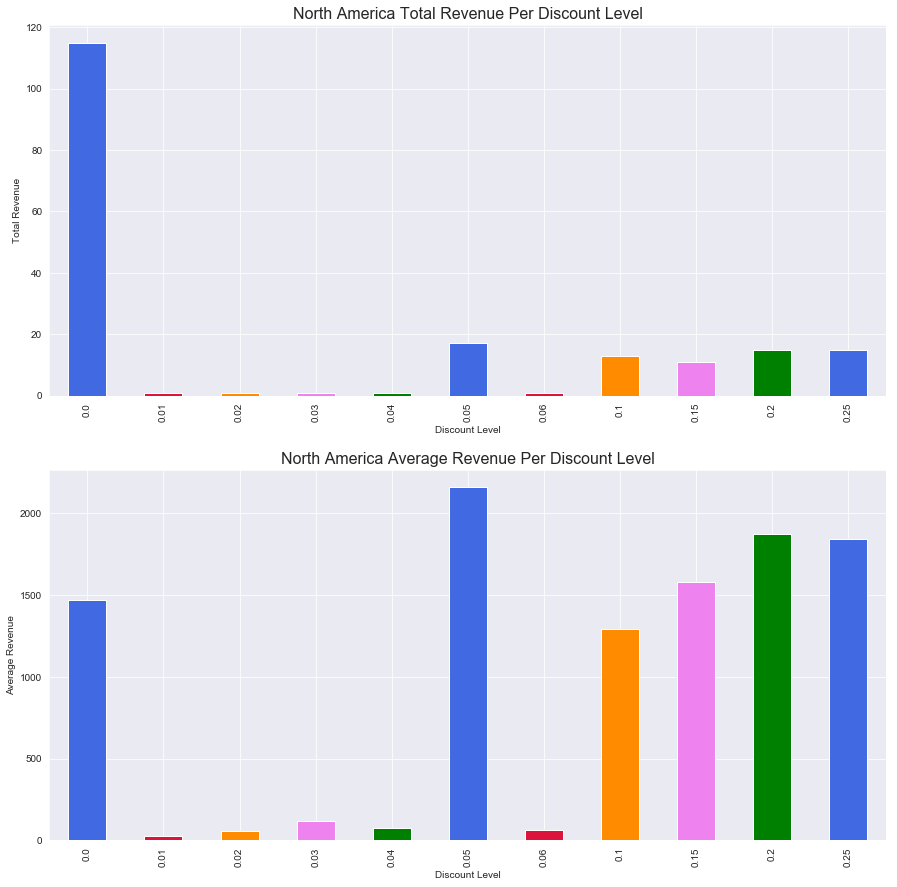

In [77]:
# Visually comparing discounts levels for North America
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
north_america.groupby(['Discount'])['Revenue'].count().plot(kind='bar', ax=ax1, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
north_america.groupby(['Discount'])['Revenue'].mean().plot(kind='bar', ax=ax2, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])

ax1.set_title('North America Total Revenue Per Discount Level', fontsize=16)
ax1.set_xlabel('Discount Level')
ax1.set_ylabel('Total Revenue')

ax2.set_title('North America Average Revenue Per Discount Level', fontsize=16)
ax2.set_xlabel('Discount Level')
ax2.set_ylabel('Average Revenue')

Visually we can see that North America offers more discount levels than other regions.  It seems that once again 0.05 discount level generates a higher average revenue per order, but also in this region 0.15, 0.2, and 0.25 have a higher average revenue as well.


In [78]:
# First we should check if there's a difference in orders with discounts and orders without
north_america_discount = north_america[north_america['Discount'] != 0.0]
north_america_nondiscount = north_america[north_america['Discount'] == 0.0]
print(len(north_america_discount))
print(len(north_america_nondiscount))

76
115


Text(0.5,1,'North America Revenue')

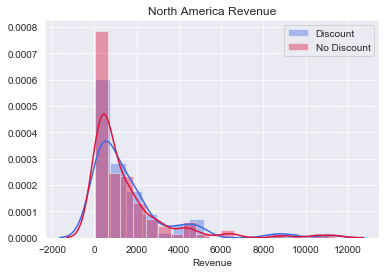

In [79]:
sns.distplot(north_america_discount.Revenue, color='royalblue', label='Discount')
sns.distplot(north_america_nondiscount.Revenue, color='crimson', label='No Discount')
plt.legend()
plt.title("North America Revenue")

In [80]:
print(np.var(north_america_discount.Revenue))
print(np.var(north_america_nondiscount.Revenue))

4248210.806330212
3839644.8745887787


Looking at the visual and the variances we are looking at positively skewed data with different variances.  So we should log transform the data and use welchs t-test.

Text(0.5,1,'North American Log Transformed Revenue')

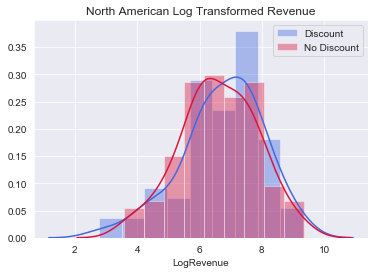

In [81]:
#Log transforming data and visualizing to check for normality
north_america_discount_log = north_america_discount.copy()
north_america_discount_log['LogRevenue'] = np.log(north_america_discount['Revenue'])
north_america_nondiscount_log = north_america_nondiscount.copy()
north_america_nondiscount_log['LogRevenue'] = np.log(north_america_nondiscount['Revenue'])
#Visualization
sns.distplot(north_america_discount_log.LogRevenue, color='royalblue', label='Discount')
sns.distplot(north_america_nondiscount_log.LogRevenue, color='crimson', label='No Discount')
plt.legend()
plt.title("North American Log Transformed Revenue")

Now with normality we can run a welch's t-test to determine if there's a significant difference between discounted orders and non-discounted orders in North America.

In [82]:
# t-test and cohen's d
welch_test_results(north_america_discount_log.LogRevenue, north_america_nondiscount_log.LogRevenue)

d = Cohen_d(north_america_discount_log.LogRevenue, north_america_nondiscount_log.LogRevenue)
print("Cohen's D:", d)

P-value result for Welch's t-test 0.2617188417309886
Cohen's D: 0.09601705839301934


Again we have a very large p-value of 0.26 so we fail to reject the null that there is a significant difference in average revenue on an order if there is a discount presence.  But looking at the bar graph it appeared that the 5% difference.  We can test it against the other discounts to see if there's a significant difference in revenue per discount level.

In [83]:
# Combining the North America dataframes that are log transformed to do ANOVA and Tukey
north_america_log = pd.concat([north_america_discount_log, north_america_nondiscount_log])
north_america_log.head()

,Region,OrderId,Discount,Revenue,LogRevenue
117,North America,10262,0.20,163.200,5.094976
118,North America,10269,0.05,642.200,6.464900
122,North America,10305,0.10,3741.300,8.227188
125,North America,10314,0.10,2094.300,7.646975
129,North America,10324,0.15,4987.715,8.514733


In [84]:
# Linear Model for ANOVA check
linear_model4 = ols('LogRevenue ~ C(Discount)', north_america_log).fit()
linear_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LogRevenue   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     2.710
Date:                Tue, 14 Apr 2020   Prob (F-statistic):            0.00402
Time:                        17:40:05   Log-Likelihood:                -302.93
No. Observations:                 191   AIC:                             627.9
Df Residuals:                     180   BIC:                             663.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.6054      0.114     58.186      0.000       6.381       6.829
C(Discount)[T.0.01]    -3.2143      1.223     -2.629      0.009      -5.627      -0.802
C(Discount)[T.0.02]    -2.5147      1.223     -2.057      0.041      -4.927      -0.102
C(Discount)[T.0.03]    -1.8104      1.223     -1.481      0.140      -4.223       0.602
C(Discount)[T.0.04]    -2.2518      1.223     -1.842      0.067      -4.664       0.161
C(Discount)[T.0.05]     0.6030      0.316      1.906      0.058      -0.021       1.227
C(Discount)[T.0.06]    -2.4478      1.223     -2.002      0.047      -4.860      -0.035
C(Discount)[T.0.1]     -0.0044      0.356     -0.012      0.990      -0.707       0.699
C(Discount)[T.0.15]     0.3017      0.384      0.785      0.433      -0.456       1.060
C(Discount)[T.0.2]      0.1674      0.334      0.501      0.617      -0.492       0.827
C(Discount)[T.0.25]     0.3669      0.334      1.098      0.274      -0.293       1.026
==============================================================================
Omnibus:                        3.024   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.220   Jarque-Bera (JB):                2.638
Skew:                          -0.272   Prob(JB):                        0.267
Kurtosis:                       3.188   Cond. No.                         14.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
#ANOVA
sm.stats.anova_lm(linear_model4, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),40.166525,10.0,2.710191,0.004023
Residual,266.769916,180.0,NaN,NaN


This p-value is 0.004 which indicates that there is a statistically significant difference in revenue when comparing different discount levels.  The previous test put all the discount levels together to compare to orders without a discount.  ANOVA tests the hypothesis that there isn't one of the revenues that is different.  With this p-value we can conclude that not all the revenue means are the same for each discount level.
We can further compare this using a Tukey multicomparison test.

In [86]:
#Tukey Multicomparison check
mc = MultiComparison(north_america_log['LogRevenue'], north_america_log['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0   0.01  -3.2143 0.2419 -7.2009 0.7724  False
   0.0   0.02  -2.5147 0.5943 -6.5014 1.4719  False
   0.0   0.03  -1.8104    0.9  -5.797 2.1763  False
   0.0   0.04  -2.2518 0.7258 -6.2384 1.7349  False
   0.0   0.05    0.603 0.6863 -0.4284 1.6345  False
   0.0   0.06  -2.4478 0.6278 -6.4344 1.5389  False
   0.0    0.1  -0.0044    0.9 -1.1659 1.1571  False
   0.0   0.15   0.3017    0.9  -0.951 1.5545  False
   0.0    0.2   0.1674    0.9 -0.9223 1.2571  False
   0.0   0.25   0.3669    0.9 -0.7228 1.4566  False
  0.01   0.02   0.6995    0.9 -4.9141 6.3132  False
  0.01   0.03   1.4039    0.9 -4.2097 7.0175  False
  0.01   0.04   0.9625    0.9 -4.6511 6.5761  False
  0.01   0.05   3.8173 0.0901 -0.2672 7.9018  False
  0.01   0.06   0.7665    0.9 -4.8471 6.3801  False
  0.01    0.1   3.2099 0.2888 -0.9094 7.3292  False
  0.01   0.1

## Central and South America Discount Check

H<sub>0</sub>: For Central and South America orders, the average revenue per order is the same regardless of discount level.

H<sub>a</sub>: For Central and South America orders, the average revenue is different for some discount levels. 

Text(0,0.5,'Average Revenue')

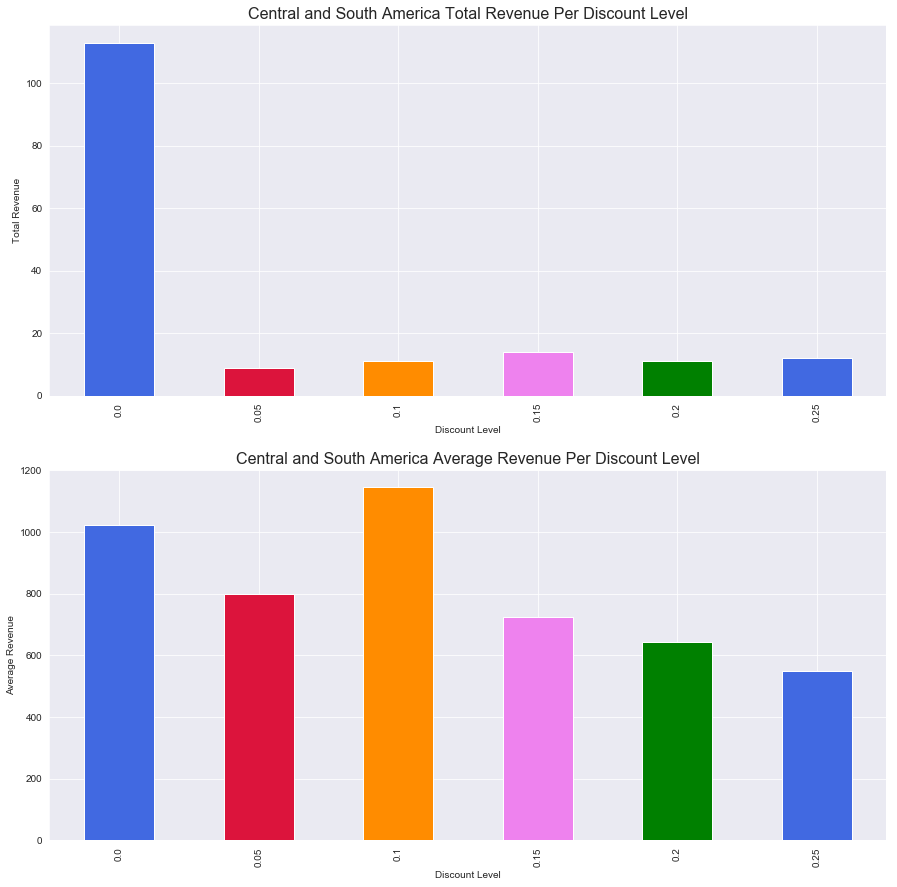

In [87]:
# Visually comparing discounts levels for Central and South America
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
central_south_america.groupby(['Discount'])['Revenue'].count().plot(kind='bar', ax=ax1, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
central_south_america.groupby(['Discount'])['Revenue'].mean().plot(kind='bar', ax=ax2, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])

ax1.set_title('Central and South America Total Revenue Per Discount Level', fontsize=16)
ax1.set_xlabel('Discount Level')
ax1.set_ylabel('Total Revenue')

ax2.set_title('Central and South America Average Revenue Per Discount Level', fontsize=16)
ax2.set_xlabel('Discount Level')
ax2.set_ylabel('Average Revenue')

Interesting result.  Once again more orders occur without a discount but the highest average revenue seems to be with a 0.10 discount level.  First let's check to see if there's a statistically significant different between revenue for discounted orders versus non-discounted orders.


In [88]:
#Splitting up the discounted from nondiscounted
central_south_america_discount = central_south_america[central_south_america['Discount'] != 0.0]
central_south_america_nondiscount = central_south_america[central_south_america['Discount'] == 0.0]

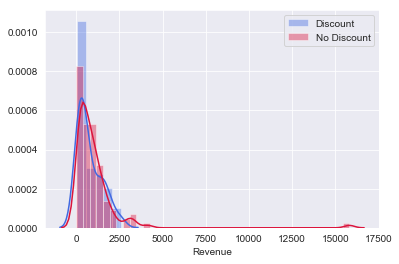

In [89]:
#Checking for normality
sns.distplot(central_south_america_discount.Revenue, color='royalblue', label='Discount')
sns.distplot(central_south_america_nondiscount.Revenue, color='crimson', label='No Discount')
plt.legend()

In [90]:
#Variance Check
print(np.var(central_south_america_discount.Revenue))
print(np.var(central_south_america_nondiscount.Revenue))

472170.1816470331
2562222.6487974627


Text(0.5,1,'Central and South America Log Transformed Revenue')

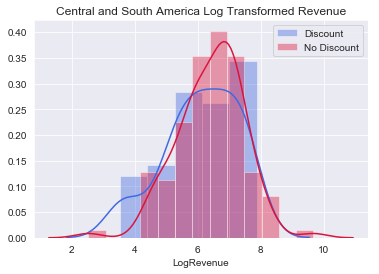

In [91]:
#Log transforming data and visualizing to check for normality
central_south_america_discount_log = central_south_america_discount.copy()
central_south_america_discount_log['LogRevenue'] = np.log(central_south_america_discount['Revenue'])
central_south_america_nondiscount_log = central_south_america_nondiscount.copy()
central_south_america_nondiscount_log['LogRevenue'] = np.log(central_south_america_nondiscount['Revenue'])
#Visualization
sns.distplot(central_south_america_discount_log.LogRevenue, color='royalblue', label='Discount')
sns.distplot(central_south_america_nondiscount_log.LogRevenue, color='crimson', label='No Discount')
plt.legend()
plt.title("Central and South America Log Transformed Revenue")

In [92]:
print(central_south_america_discount_log.LogRevenue.mean())
print(central_south_america_nondiscount_log.LogRevenue.mean())
print(central_south_america_discount.Revenue.mean())
print(central_south_america_nondiscount.Revenue.mean())

6.107343428288142
6.413855940741614
765.1268070175439
1023.2184070796461


In [93]:
# Running a Welch's t-test now that our data is normally distributed
# t-test and cohen's d
welch_test_results(central_south_america_discount_log.LogRevenue, central_south_america_nondiscount_log.LogRevenue)

d = Cohen_d(central_south_america_discount_log.LogRevenue, central_south_america_nondiscount_log.LogRevenue)
print("Cohen's D:", d)

P-value result for Welch's t-test 0.050691100465368066
Cohen's D: -0.28028626336210055


We see that the P-value in this case is very small close to our alpha value of 0.05.  So that means we reject the hypothesis that the revenue means are the same.  However Cohen's D is -0.28 so that means that the average revenue from discounted orders is less than non-discounted orders. 

In [94]:
#Combining log transformed data
central_south_america_log = pd.concat([central_south_america_discount_log, central_south_america_nondiscount_log])
central_south_america.head()

,Region,OrderId,Discount,Revenue
88,Central and South America,10259,0.0,100.8
89,Central and South America,10276,0.0,420.0
90,Central and South America,10293,0.0,848.7
91,Central and South America,10304,0.0,954.4
92,Central and South America,10308,0.0,88.8


In [95]:
# Linear Model for ANOVA check
linear_model6 = ols('LogRevenue ~ C(Discount)', central_south_america_log).fit()
linear_model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LogRevenue   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.703
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.137
Time:                        17:40:08   Log-Likelihood:                -252.57
No. Observations:                 170   AIC:                             517.1
Df Residuals:                     164   BIC:                             535.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.4139      0.102     62.642      0.000       6.212       6.616
C(Discount)[T.0.05]    -0.3513      0.377     -0.932      0.353      -1.096       0.393
C(Discount)[T.0.1]      0.2070      0.344      0.602      0.548      -0.472       0.886
C(Discount)[T.0.15]    -0.1965      0.308     -0.637      0.525      -0.805       0.412
C(Discount)[T.0.2]     -0.3406      0.344     -0.991      0.323      -1.019       0.338
C(Discount)[T.0.25]    -0.8407      0.330     -2.544      0.012      -1.493      -0.188
==============================================================================
Omnibus:                        8.080   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.033
Skew:                          -0.448   Prob(JB):                       0.0180
Kurtosis:                       3.576   Cond. No.                         4.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
#ANOVA
sm.stats.anova_lm(linear_model6, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),10.084711,5.0,1.702597,0.136758
Residual,194.278836,164.0,NaN,NaN


We can conclude from our two tests that there isn't a significant difference between discounted orders and nondiscounted orders and the revenue and that when it is broken down by discount level, there still isn't a statistical significant difference.

## Scandinavia and Northern Europe

H<sub>0</sub>: For Scandinavia and Northern Europe orders, the average revenue per order is the same regardless of discount level.

H<sub>a</sub>: For Scandinavia and Northern Europe orders, the average revenue is different for some discount levels. 

Text(0,0.5,'Average Revenue')

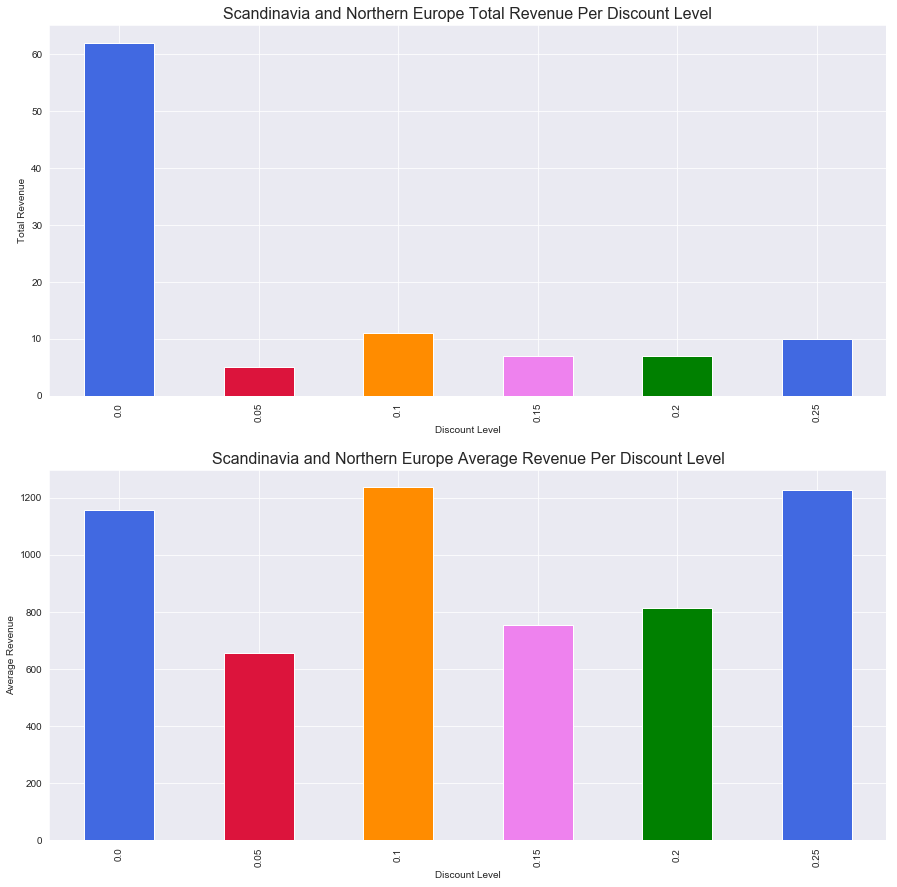

In [97]:
# Visually comparing discounts levels for Scandinavia and Northern Europe
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
scandinavia_northern_europe.groupby(['Discount'])['Revenue'].count().plot(kind='bar', ax=ax1, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
scandinavia_northern_europe.groupby(['Discount'])['Revenue'].mean().plot(kind='bar', ax=ax2, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])

ax1.set_title('Scandinavia and Northern Europe Total Revenue Per Discount Level', fontsize=16)
ax1.set_xlabel('Discount Level')
ax1.set_ylabel('Total Revenue')

ax2.set_title('Scandinavia and Northern Europe Average Revenue Per Discount Level', fontsize=16)
ax2.set_xlabel('Discount Level')
ax2.set_ylabel('Average Revenue')

In [138]:
scandinavia_northern_europe['Discount'].value_counts()

0.00    62
0.10    11
0.25    10
0.20     7
0.15     7
0.05     5
Name: Discount, dtype: int64

This result is similar to North America's result with the 0.1 and 0.25 returning a higher average revenue per order.

In [98]:
#Splitting up the discounted from nondiscounted
scandinavia_northern_europe_discount = scandinavia_northern_europe[scandinavia_northern_europe['Discount'] != 0.0]
scandinavia_northern_europe_nondiscount = scandinavia_northern_europe[scandinavia_northern_europe['Discount'] == 0.0]

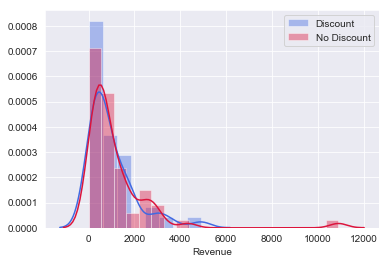

In [99]:
#Checking for normality
sns.distplot(scandinavia_northern_europe_discount.Revenue, color='royalblue', label='Discount')
sns.distplot(scandinavia_northern_europe_nondiscount.Revenue, color='crimson', label='No Discount')
plt.legend()

In [100]:
#Variance Check
print(np.var(scandinavia_northern_europe_discount.Revenue))
print(np.var(scandinavia_northern_europe_nondiscount.Revenue))

1078651.7675023593
2383959.90660835


Text(0.5,1,'Scandinavia and Northern Europe Log Transformed Revenue')

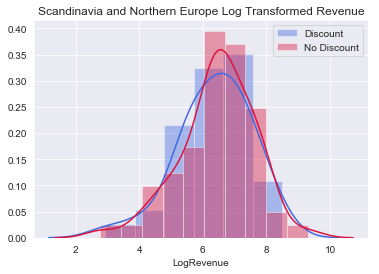

In [101]:
#Log transforming data and visualizing to check for normality
scandinavia_northern_europe_discount_log = scandinavia_northern_europe_discount.copy()
scandinavia_northern_europe_discount_log['LogRevenue'] = np.log(scandinavia_northern_europe_discount['Revenue'])
scandinavia_northern_europe_nondiscount_log = scandinavia_northern_europe_nondiscount.copy()
scandinavia_northern_europe_nondiscount_log['LogRevenue'] = np.log(scandinavia_northern_europe_nondiscount['Revenue'])
#Visualization
sns.distplot(scandinavia_northern_europe_discount_log.LogRevenue, color='royalblue', label='Discount')
sns.distplot(scandinavia_northern_europe_nondiscount_log.LogRevenue, color='crimson', label='No Discount')
plt.legend()
plt.title("Scandinavia and Northern Europe Log Transformed Revenue")

In [102]:
print(scandinavia_northern_europe_discount_log.LogRevenue.mean())
print(scandinavia_northern_europe_nondiscount_log.LogRevenue.mean())
print(scandinavia_northern_europe_discount.Revenue.mean())
print(scandinavia_northern_europe_nondiscount.Revenue.mean())

6.368153660354231
6.463029907627992
1001.922875
1155.2330645161292


In [103]:
# Running a Welch's t-test now that our data is normally distributed
# t-test and cohen's d
welch_test_results(scandinavia_northern_europe_discount_log.LogRevenue, scandinavia_northern_europe_nondiscount_log.LogRevenue)

d = Cohen_d(scandinavia_northern_europe_discount_log.LogRevenue, scandinavia_northern_europe_nondiscount_log.LogRevenue)
print("Cohen's D:", d)

P-value result for Welch's t-test 0.3460701663459107
Cohen's D: -0.08048369851255344


In [104]:
scandinavia_northern_europe_log = pd.concat([scandinavia_northern_europe_discount_log, scandinavia_northern_europe_nondiscount_log])
scandinavia_northern_europe_log.head()

,Region,OrderId,Discount,Revenue,LogRevenue
308,Scandinavia and Northern Europe,10264,0.15,163.625,5.097577
311,Scandinavia and Northern Europe,10327,0.20,1810.000,7.501082
313,Scandinavia and Northern Europe,10341,0.15,336.600,5.818895
319,Scandinavia and Northern Europe,10417,0.25,284.400,5.650382
321,Scandinavia and Northern Europe,10434,0.15,220.320,5.395081


In [105]:
# Linear Model for ANOVA check
linear_model7 = ols('LogRevenue ~ C(Discount)', scandinavia_northern_europe_log).fit()
linear_model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LogRevenue   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.3124
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.904
Time:                        17:40:10   Log-Likelihood:                -159.76
No. Observations:                 102   AIC:                             331.5
Df Residuals:                      96   BIC:                             347.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.4630      0.152     42.606      0.000       6.162       6.764
C(Discount)[T.0.05]    -0.2025      0.555     -0.365      0.716      -1.305       0.900
C(Discount)[T.0.1]      0.2428      0.391      0.621      0.536      -0.533       1.018
C(Discount)[T.0.15]    -0.1278      0.476     -0.268      0.789      -1.073       0.818
C(Discount)[T.0.2]     -0.1455      0.476     -0.305      0.761      -1.091       0.800
C(Discount)[T.0.25]    -0.3541      0.407     -0.870      0.387      -1.162       0.454
==============================================================================
Omnibus:                        6.488   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.918
Skew:                          -0.521   Prob(JB):                       0.0519
Kurtosis:                       3.554   Cond. No.                         5.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
#ANOVA
sm.stats.anova_lm(linear_model7, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),2.228309,5.0,0.312387,0.904448
Residual,136.956803,96.0,NaN,NaN


From the welch's t-test and the ANOVA test we see that the P-values lead us to fail to reject the null hypothesis that there is a significant difference between discounted orders revenue and nondiscounted orders revenue.

## Southern and Eastern Europe Check

H<sub>0</sub>: For Southern and Eastern Europe orders, the average revenue per order is the same regardless of discount level.

H<sub>a</sub>: For Southern and Eastern Europe orders, the average revenue is different for some discount levels. 

Text(0,0.5,'Average Revenue')

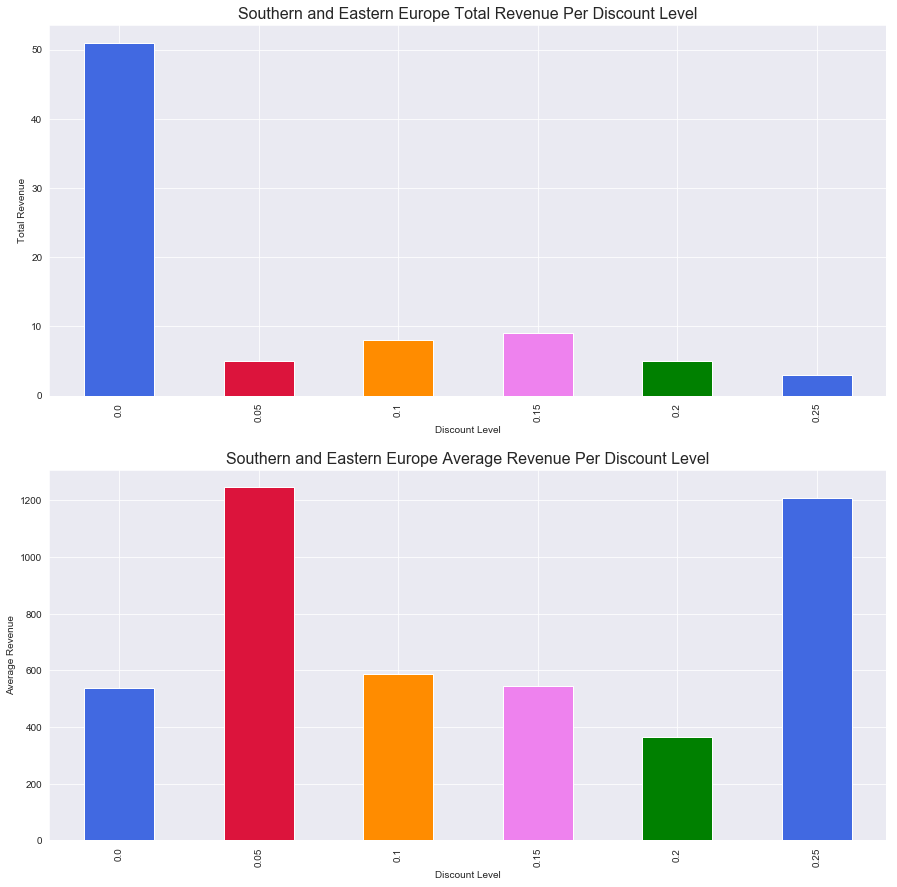

In [107]:
# Visually comparing discounts levels for Scandinavia and Northern Europe
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
south_eastern_europe.groupby(['Discount'])['Revenue'].count().plot(kind='bar', ax=ax1, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
south_eastern_europe.groupby(['Discount'])['Revenue'].mean().plot(kind='bar', ax=ax2, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])

ax1.set_title('Southern and Eastern Europe Total Revenue Per Discount Level', fontsize=16)
ax1.set_xlabel('Discount Level')
ax1.set_ylabel('Total Revenue')

ax2.set_title('Southern and Eastern Europe Average Revenue Per Discount Level', fontsize=16)
ax2.set_xlabel('Discount Level')
ax2.set_ylabel('Average Revenue')

In [137]:
south_eastern_europe['Discount'].value_counts()

0.00    51
0.15     9
0.10     8
0.05     5
0.20     5
0.25     3
Name: Discount, dtype: int64

For Southern and Eastern Europe we see a much greater difference in average revenue per order with 0.05 and 0.25 disount levels.

In [108]:
#Splitting up the discounted from nondiscounted
south_eastern_europe_discount = south_eastern_europe[south_eastern_europe['Discount'] != 0.0]
south_eastern_europe_nondiscount = south_eastern_europe[south_eastern_europe['Discount'] == 0.0]

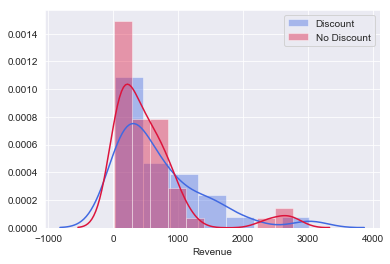

In [109]:
#Checking for normality
sns.distplot(south_eastern_europe_discount.Revenue, color='royalblue', label='Discount')
sns.distplot(south_eastern_europe_nondiscount.Revenue, color='crimson', label='No Discount')
plt.legend()

In [110]:
#Variance Check
print(np.var(south_eastern_europe_discount.Revenue))
print(np.var(south_eastern_europe_nondiscount.Revenue))

463630.6151371459
353259.0425797771


Text(0.5,1,'Southern and Eastern Europe Log Transformed Revenue')

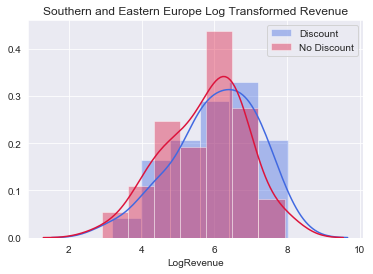

In [111]:
#Log transforming data and visualizing to check for normality
south_eastern_europe_discount_log = south_eastern_europe_discount.copy()
south_eastern_europe_discount_log['LogRevenue'] = np.log(south_eastern_europe_discount['Revenue'])
south_eastern_europe_nondiscount_log = south_eastern_europe_nondiscount.copy()
south_eastern_europe_nondiscount_log['LogRevenue'] = np.log(south_eastern_europe_nondiscount['Revenue'])
#Visualization
sns.distplot(south_eastern_europe_discount_log.LogRevenue, color='royalblue', label='Discount')
sns.distplot(south_eastern_europe_nondiscount_log.LogRevenue, color='crimson', label='No Discount')
plt.legend()
plt.title("Southern and Eastern Europe Log Transformed Revenue")

Fairly normal with different variances so we can run a welch's test.

In [112]:
# Running a Welch's t-test now that our data is normally distributed
# t-test and cohen's d
welch_test_results(south_eastern_europe_discount_log.LogRevenue, south_eastern_europe_nondiscount_log.LogRevenue)

d = Cohen_d(south_eastern_europe_discount_log.LogRevenue, south_eastern_europe_nondiscount_log.LogRevenue)
print("Cohen's D:", d)

P-value result for Welch's t-test 0.1357729599236921
Cohen's D: 0.25748097827794636


The p-value indicates there isn't a significant difference between non-discounted order revenue and discounted order revenues.

In [113]:
south_eastern_europe_log = pd.concat([south_eastern_europe_discount_log, south_eastern_europe_nondiscount_log])
south_eastern_europe_log.head()

,Region,OrderId,Discount,Revenue,LogRevenue
558,Southern and Eastern Europe,10275,0.05,291.84,5.676206
561,Southern and Eastern Europe,10288,0.10,80.10,4.383276
563,Southern and Eastern Europe,10303,0.10,1117.80,7.019118
567,Southern and Eastern Europe,10336,0.10,285.12,5.652910
569,Southern and Eastern Europe,10352,0.15,100.30,4.608166


In [114]:
# Linear Model for ANOVA check
linear_model8 = ols('LogRevenue ~ C(Discount)', south_eastern_europe_log).fit()
linear_model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LogRevenue   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.318
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.266
Time:                        17:40:12   Log-Likelihood:                -121.21
No. Observations:                  81   AIC:                             254.4
Df Residuals:                      75   BIC:                             268.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.7555      0.157     36.601      0.000       5.442       6.069
C(Discount)[T.0.05]     1.1581      0.526      2.201      0.031       0.110       2.206
C(Discount)[T.0.1]      0.3102      0.427      0.726      0.470      -0.541       1.161
C(Discount)[T.0.15]    -0.0654      0.406     -0.161      0.873      -0.874       0.743
C(Discount)[T.0.2]     -0.2134      0.526     -0.406      0.686      -1.262       0.835
C(Discount)[T.0.25]     0.7103      0.667      1.065      0.290      -0.619       2.039
==============================================================================
Omnibus:                        2.355   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.308   Jarque-Bera (JB):                2.341
Skew:                          -0.371   Prob(JB):                        0.310
Kurtosis:                       2.623   Cond. No.                         5.55
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
#ANOVA
sm.stats.anova_lm(linear_model8, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),8.311275,5.0,1.318113,0.265605
Residual,94.581510,75.0,NaN,NaN


In [135]:
mc = MultiComparison(south_eastern_europe_log['LogRevenue'], south_eastern_europe_log['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0   0.05   1.1581 0.2496 -0.3809 2.6972  False
   0.0    0.1   0.3102    0.9 -0.9387 1.5591  False
   0.0   0.15  -0.0654    0.9 -1.2528  1.122  False
   0.0    0.2  -0.2134    0.9 -1.7525 1.3256  False
   0.0   0.25   0.7103 0.8916 -1.2409 2.6614  False
  0.05    0.1   -0.848 0.7442 -2.7203 1.0244  False
  0.05   0.15  -1.2235 0.3799 -3.0554 0.6084  False
  0.05    0.2  -1.3716 0.3932 -3.4487 0.7056  False
  0.05   0.25  -0.4479    0.9 -2.8464 1.9506  False
   0.1   0.15  -0.3756    0.9 -1.9714 1.2203  False
   0.1    0.2  -0.5236    0.9 -2.3959 1.3487  False
   0.1   0.25   0.4001    0.9 -1.8234 2.6235  False
  0.15    0.2  -0.1481    0.9 -1.9799 1.6838  False
  0.15   0.25   0.7756    0.9 -1.4139 2.9652  False
   0.2   0.25   0.9237 0.8566 -1.4748 3.3222  False
---------------------------------------------------
[0.   0.05 0

Based on the t-test, anova, and tukey test we can conclude that we fail to reject the null hypothesis that there is a statistically significant difference between discounted orders and nondiscounted orders and the revenue produced for Southern and Eastern Europe.

## British Isles Check

H<sub>0</sub>: For British Isles orders, the average revenue per order is the same regardless of discount level.

H<sub>a</sub>: For British Isles orders, the average revenue is different for some discount levels. 

Text(0,0.5,'Average Revenue')

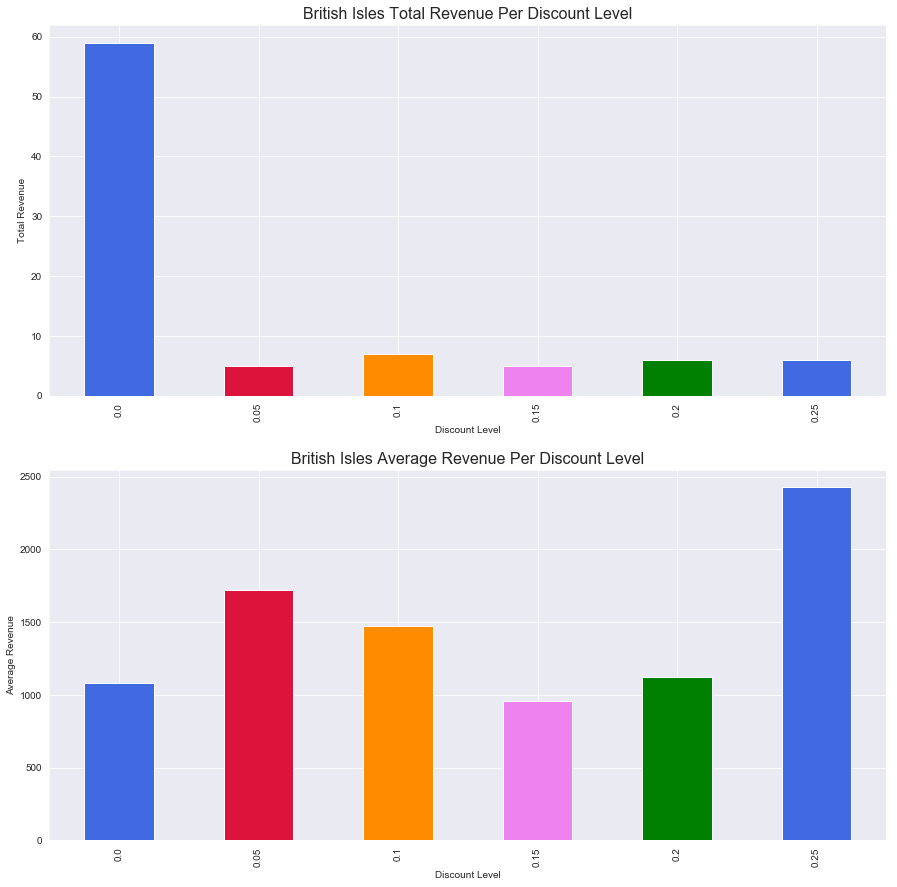

In [116]:
# Visually comparing discounts levels for Scandinavia and Northern Europe
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
british_isles.groupby(['Discount'])['Revenue'].count().plot(kind='bar', ax=ax1, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
british_isles.groupby(['Discount'])['Revenue'].mean().plot(kind='bar', ax=ax2, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])

ax1.set_title('British Isles Total Revenue Per Discount Level', fontsize=16)
ax1.set_xlabel('Discount Level')
ax1.set_ylabel('Total Revenue')

ax2.set_title('British Isles Average Revenue Per Discount Level', fontsize=16)
ax2.set_xlabel('Discount Level')
ax2.set_ylabel('Average Revenue')

In [139]:
british_isles['Discount'].value_counts()

0.00    59
0.10     7
0.20     6
0.25     6
0.05     5
0.15     5
Name: Discount, dtype: int64

In [117]:
#Splitting up the discounted from nondiscounted
british_isles_discount = british_isles[british_isles['Discount'] != 0.0]
british_isles_nondiscount = british_isles[british_isles['Discount'] == 0.0]

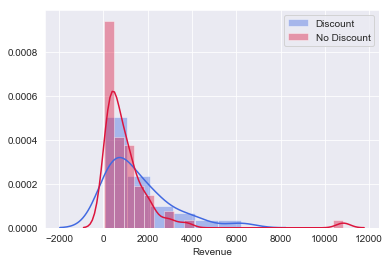

In [118]:
#Checking for normality
sns.distplot(british_isles_discount.Revenue, color='royalblue', label='Discount')
sns.distplot(british_isles_nondiscount.Revenue, color='crimson', label='No Discount')
plt.legend()

In [119]:
#Variance Check
print(np.var(british_isles_discount.Revenue))
print(np.var(british_isles_nondiscount.Revenue))

2074296.045054994
2238806.9387003165


Text(0.5,1,'British Isles Log Transformed Revenue')

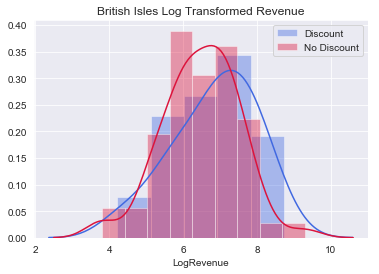

In [120]:
#Log transforming data and visualizing to check for normality
british_isles_discount_log = british_isles_discount.copy()
british_isles_discount_log['LogRevenue'] = np.log(british_isles_discount['Revenue'])
british_isles_nondiscount_log = british_isles_nondiscount.copy()
british_isles_nondiscount_log['LogRevenue'] = np.log(british_isles_nondiscount['Revenue'])
#Visualization
sns.distplot(british_isles_discount_log.LogRevenue, color='royalblue', label='Discount')
sns.distplot(british_isles_nondiscount_log.LogRevenue, color='crimson', label='No Discount')
plt.legend()
plt.title("British Isles Log Transformed Revenue")

In [121]:
# Running a Welch's t-test now that our data is normally distributed
# t-test and cohen's d
welch_test_results(british_isles_discount_log.LogRevenue, british_isles_nondiscount_log.LogRevenue)

d = Cohen_d(british_isles_discount_log.LogRevenue, british_isles_nondiscount_log.LogRevenue)
print("Cohen's D:", d)

P-value result for Welch's t-test 0.07845518259586082
Cohen's D: 0.338197207989168


There is no significant difference between discounted and not discounted orders.

In [122]:
british_isles_log = pd.concat([british_isles_discount_log, british_isles_nondiscount_log])
british_isles_log.head()

,Region,OrderId,Discount,Revenue,LogRevenue
2,British Isles,10298,0.25,1446.00,7.276556
7,British Isles,10335,0.20,2036.16,7.618821
9,British Isles,10359,0.05,3471.68,8.152394
11,British Isles,10373,0.20,1366.40,7.219935
12,British Isles,10377,0.15,863.60,6.761110


In [123]:
# Linear Model for ANOVA check
linear_model9 = ols('LogRevenue ~ C(Discount)', british_isles_log).fit()
linear_model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LogRevenue   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.519
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.193
Time:                        17:40:13   Log-Likelihood:                -126.87
No. Observations:                  88   AIC:                             265.7
Df Residuals:                      82   BIC:                             280.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.4809      0.138     46.974      0.000       6.206       6.755
C(Discount)[T.0.05]     0.0123      0.494      0.025      0.980      -0.970       0.994
C(Discount)[T.0.1]      0.6698      0.424      1.581      0.118      -0.173       1.513
C(Discount)[T.0.15]    -0.2210      0.494     -0.448      0.656      -1.203       0.761
C(Discount)[T.0.2]      0.1131      0.454      0.249      0.804      -0.790       1.017
C(Discount)[T.0.25]     1.0258      0.454      2.259      0.027       0.122       1.929
==============================================================================
Omnibus:                        0.723   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.696   Jarque-Bera (JB):                0.409
Skew:                          -0.158   Prob(JB):                        0.815
Kurtosis:                       3.107   Cond. No.                         4.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
#ANOVA
sm.stats.anova_lm(linear_model9, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),8.527680,5.0,1.51863,0.193026
Residual,92.092194,82.0,NaN,NaN


From both tests we can conclude that there is not a statistically significant difference in revenue derived from orders regardless if there is a discount and at what level the discount is offered.

## Change of approach
Looking at the sample sizes for all of the European Regions apart from Western Europe it seems to run these tests would be inconclusive because there aren't enough discounted samples to be able to compare.
I think I should combine the rest of Europe to do a discount check.

In [142]:
rest_of_europe = pd.concat([british_isles, scandinavia_northern_europe, south_eastern_europe])
rest_of_europe.head()

,Region,OrderId,Discount,Revenue
0,British Isles,10289,0.00,479.4
1,British Isles,10298,0.00,1199.0
2,British Isles,10298,0.25,1446.0
3,British Isles,10309,0.00,1762.0
4,British Isles,10315,0.00,516.8


In [143]:
rest_of_europe['Discount'].value_counts()

0.00    172
0.10     26
0.15     21
0.25     19
0.20     18
0.05     15
Name: Discount, dtype: int64

Text(0,0.5,'Average Revenue')

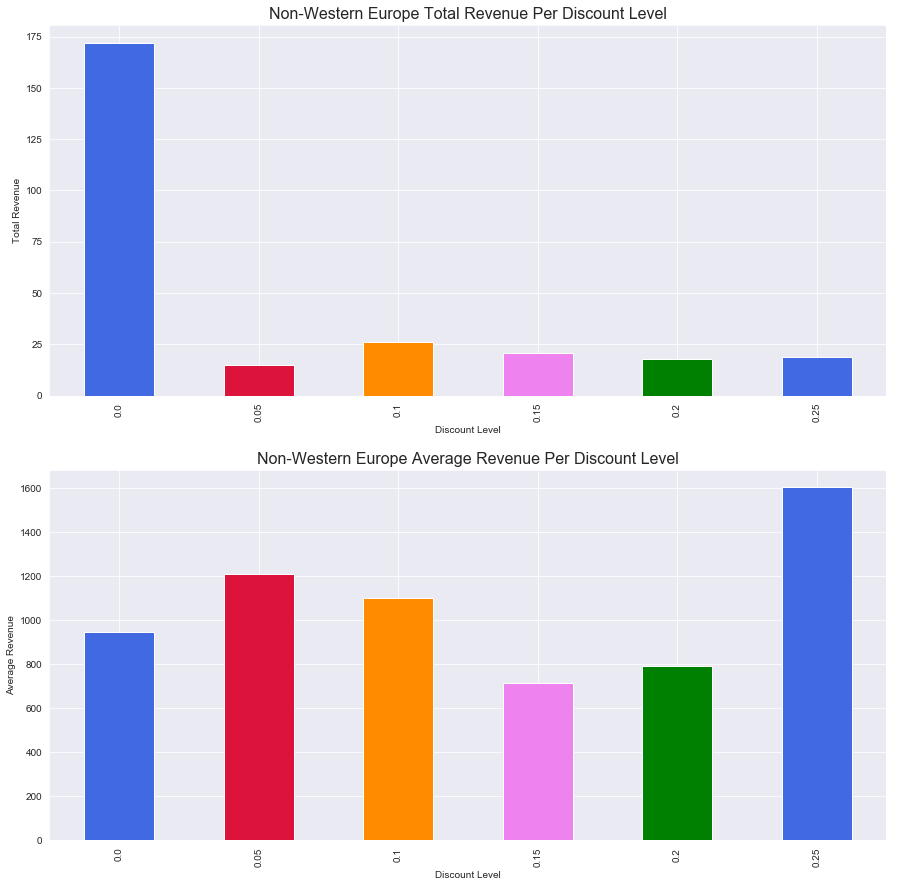

In [144]:
# Visually comparing discounts levels for Scandinavia and Northern Europe
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
rest_of_europe.groupby(['Discount'])['Revenue'].count().plot(kind='bar', ax=ax1, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])
rest_of_europe.groupby(['Discount'])['Revenue'].mean().plot(kind='bar', ax=ax2, color=['royalblue', 'crimson', 'darkorange', 'violet','green'])

ax1.set_title('Non-Western Europe Total Revenue Per Discount Level', fontsize=16)
ax1.set_xlabel('Discount Level')
ax1.set_ylabel('Total Revenue')

ax2.set_title('Non-Western Europe Average Revenue Per Discount Level', fontsize=16)
ax2.set_xlabel('Discount Level')
ax2.set_ylabel('Average Revenue')

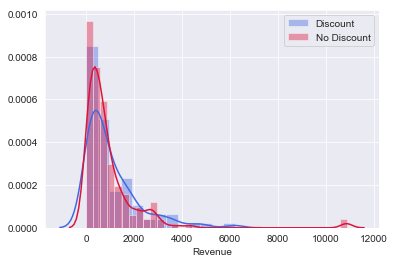

In [146]:
#Splitting up the discounted from nondiscounted
rest_of_europe_discount = rest_of_europe[rest_of_europe['Discount'] != 0.0]
rest_of_europe_nondiscount = rest_of_europe[rest_of_europe['Discount'] == 0.0]
#Checking for normality
sns.distplot(rest_of_europe_discount.Revenue, color='royalblue', label='Discount')
sns.distplot(rest_of_europe_nondiscount.Revenue, color='crimson', label='No Discount')
plt.legend()

Text(0.5,1,'Non-Western Europe Log Transformed Revenue')

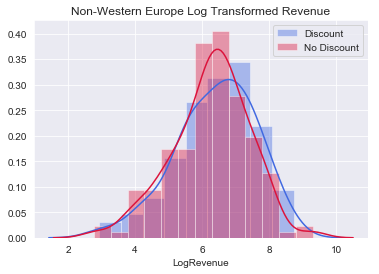

In [147]:
#Log transforming data and visualizing to check for normality
rest_of_europe_discount_log = rest_of_europe_discount.copy()
rest_of_europe_discount_log['LogRevenue'] = np.log(rest_of_europe_discount['Revenue'])
rest_of_europe_nondiscount_log = rest_of_europe_nondiscount.copy()
rest_of_europe_nondiscount_log['LogRevenue'] = np.log(rest_of_europe_nondiscount['Revenue'])
#Visualization
sns.distplot(rest_of_europe_discount_log.LogRevenue, color='royalblue', label='Discount')
sns.distplot(rest_of_europe_nondiscount_log.LogRevenue, color='crimson', label='No Discount')
plt.legend()
plt.title("Non-Western Europe Log Transformed Revenue")

In [148]:
# Running a Welch's t-test now that our data is normally distributed
# t-test and cohen's d
welch_test_results(rest_of_europe_discount_log.LogRevenue, rest_of_europe_nondiscount_log.LogRevenue)

d = Cohen_d(rest_of_europe_discount_log.LogRevenue, rest_of_europe_nondiscount_log.LogRevenue)
print("Cohen's D:", d)

P-value result for Welch's t-test 0.15617475798043612
Cohen's D: 0.12886512059857244


In [150]:
rest_of_europe_log = pd.concat([rest_of_europe_discount_log, rest_of_europe_nondiscount_log])
linear_model11 = ols('LogRevenue ~ C(Discount)', rest_of_europe_log).fit()
linear_model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LogRevenue   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.091
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.366
Time:                        17:59:05   Log-Likelihood:                -423.09
No. Observations:                 271   AIC:                             858.2
Df Residuals:                     265   BIC:                             879.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.2594      0.089     70.412      0.000       6.084       6.434
C(Discount)[T.0.05]     0.2964      0.314      0.944      0.346      -0.322       0.914
C(Discount)[T.0.1]      0.3693      0.245      1.505      0.133      -0.114       0.852
C(Discount)[T.0.15]    -0.2185      0.269     -0.811      0.418      -0.749       0.312
C(Discount)[T.0.2]     -0.0651      0.289     -0.225      0.822      -0.634       0.504
C(Discount)[T.0.25]     0.3473      0.282      1.232      0.219      -0.208       0.902
==============================================================================
Omnibus:                        9.559   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.581
Skew:                          -0.448   Prob(JB):                      0.00831
Kurtosis:                       3.215   Cond. No.                         4.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [151]:
#ANOVA
sm.stats.anova_lm(linear_model11, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),7.416665,5.0,1.0913,0.365512
Residual,360.197344,265.0,NaN,NaN


We can see that even with Eastern, Southern, Northern Europe as well as the British Isles and Scandinavia - discounts are not statistically significant in their impact on revenue.

## Question 4

## Was the sales performance of the offices from different cities the same?  



H<sub>0</sub>: Sales across the different offices was the same.

H<sub>a</sub>: Sales across the different offices differed.

In [125]:
# Getting the information about various employees
cur.execute("""Select * 
               From Employee
;""")
Employee = pd.DataFrame(cur.fetchall())
Employee.columns = [x[0] for x in cur.description]
Employee

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp
5,6,Suyama,Michael,Sales Representative,Mr.,1995-07-02,2025-10-17,Coventry House Miner Rd.,London,British Isles,EC2 7JR,UK,(71) 555-7773,428,None,Michael is a graduate of Sussex University (MA...,5.0,http://accweb/emmployees/davolio.bmp
6,7,King,Robert,Sales Representative,Mr.,1992-05-29,2026-01-02,Edgeham Hollow Winchester Way,London,British Isles,RG1 9SP,UK,(71) 555-5598,465,None,Robert King served in the Peace Corps and trav...,5.0,http://accweb/emmployees/davolio.bmp
7,8,Callahan,Laura,Inside Sales Coordinator,Ms.,1990-01-09,2026-03-05,4726 - 11th Ave. N.E.,Seattle,North America,98105,USA,(206) 555-1189,2344,None,Laura received a BA in psychology from the Uni...,2.0,http://accweb/emmployees/davolio.bmp
8,9,Dodsworth,Anne,Sales Representative,Ms.,1998-01-27,2026-11-15,7 Houndstooth Rd.,London,British Isles,WG2 7LT,UK,(71) 555-4444,452,None,Anne has a BA degree in English from St. Lawre...,5.0,http://accweb/emmployees/davolio.bmp


In [126]:
# Aggregating sales data from each office
cur.execute("""Select od.OrderId,
                      od.ProductId,
                      od.UnitPrice*od.Quantity*(1-od.Discount) as Revenue,
                      e.Region,
                      e.City,
                      e.Country
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Join Employee e
               On e.Id = o.EmployeeId
               Group by 1         
;""")
Sales_per_office = pd.DataFrame(cur.fetchall())
Sales_per_office.columns = [x[0] for x in cur.description]
Sales_per_office.head()

,OrderId,ProductId,Revenue,Region,City,Country
0,10248,11,168.00,British Isles,London,UK
1,10249,14,167.40,British Isles,London,UK
2,10250,41,77.00,North America,Redmond,USA
3,10251,22,95.76,North America,Kirkland,USA
4,10252,20,2462.40,North America,Redmond,USA


In [127]:
print(len(Sales_per_office))
Sales_per_office['City'].value_counts()

830


Seattle     227
London      224
Redmond     156
Kirkland    127
Tacoma       96
Name: City, dtype: int64

In [128]:
for city in Sales_per_office['City'].unique():
    print(city, Sales_per_office[Sales_per_office['City']==city]['Revenue'].mean())

London 516.104015625
Redmond 589.216858974359
Kirkland 563.3708503937007
Seattle 592.7285969162997
Tacoma 638.4319791666667


Above we can see that we are looking at 830 orders that went to our 5 offices.  Looking at the mean revenue for each city we can see that they are similar with Tacoma being the higher performing and London is on the lower end.

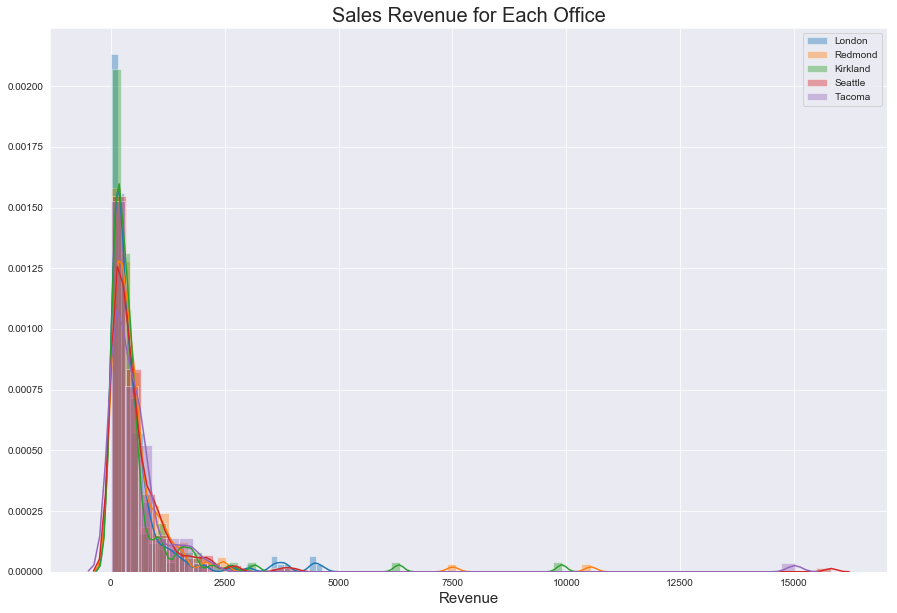

In [129]:
#Normality check
plt.figure(figsize=(15,10))
for city in Sales_per_office['City'].unique():
    sns.distplot(Sales_per_office[Sales_per_office['City']==city]['Revenue'], label=city)
plt.title('Sales Revenue for Each Office', fontsize=20)
plt.xlabel('Revenue', fontsize=15)
plt.legend()

In [130]:
# Variance Check
for city in Sales_per_office['City'].unique():
    print(city, (Sales_per_office[Sales_per_office['City']==city]['Revenue'].var()))

London 595156.1245059673
Redmond 1179800.8373595057
Kirkland 1245263.708118176
Seattle 1386225.4119791389
Tacoma 2437203.667506567


In [152]:
# Variance Check
for city in Sales_per_office['City'].unique():
    print(city, (Sales_per_office[Sales_per_office['City']==city]['Revenue'].sum()))

London 115607.2995
Redmond 91917.83
Kirkland 71548.098
Seattle 134549.39150000003
Tacoma 61289.47


We see a large difference in the variances of each city.  Along with that the distribution of Revenue for each office is positively skewed.  The 4 US cities are highly varied with double or more of the variance of the London office. In order to run ANOVA and Tukey we need to normalize the data.

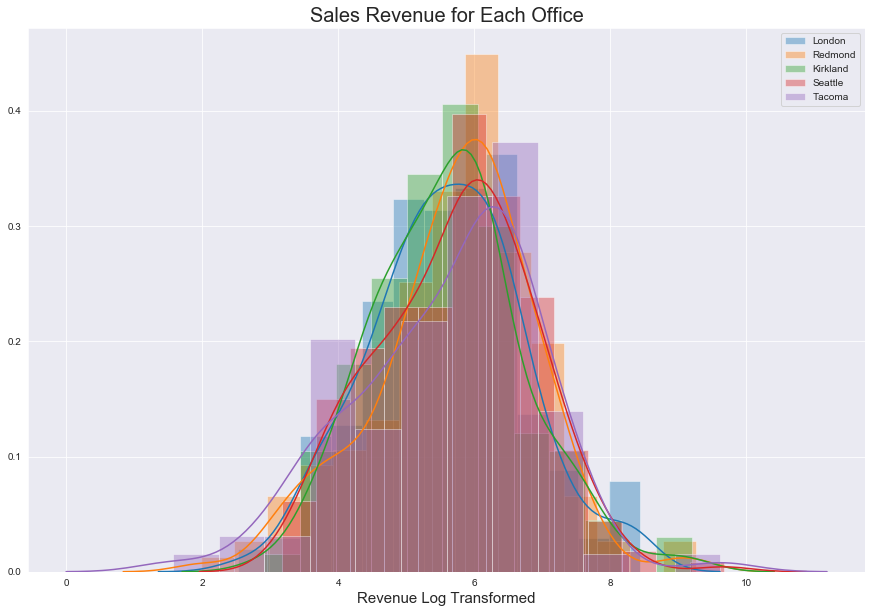

In [131]:
# Log Transformation
Sales_per_office_log = Sales_per_office.copy()
Sales_per_office_log['LogRevenue'] = np.log(Sales_per_office['Revenue'])
Sales_per_office_log.head()
#Normality check
plt.figure(figsize=(15,10))
for city in Sales_per_office['City'].unique():
    sns.distplot(Sales_per_office_log[Sales_per_office_log['City']==city]['LogRevenue'], label=city)
plt.title('Sales Revenue for Each Office', fontsize=20)
plt.xlabel('Revenue Log Transformed', fontsize=15)
plt.legend()

Now that we've normalized the data we can run an ANOVA test to see if there is a significant difference between the revenue of each  city.

In [132]:
# Linear Model for ANOVA check
linear_model10 = ols('LogRevenue ~ C(City)', Sales_per_office_log).fit()
linear_model10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LogRevenue   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5075
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.730
Time:                        17:40:16   Log-Likelihood:                -1301.9
No. Observations:                 830   AIC:                             2614.
Df Residuals:                     825   BIC:                             2637.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.6269      0.103     54.436      0.000       5.424       5.830
C(City)[T.London]     -0.0301      0.129     -0.233      0.816      -0.284       0.224
C(City)[T.Redmond]     0.0890      0.139      0.639      0.523      -0.184       0.362
C(City)[T.Seattle]     0.1030      0.129      0.798      0.425      -0.150       0.356
C(City)[T.Tacoma]     -0.0039      0.158     -0.025      0.980      -0.313       0.305
==============================================================================
Omnibus:                        2.405   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                2.349
Skew:                          -0.071   Prob(JB):                        0.309
Kurtosis:                       3.218   Cond. No.                         6.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
#ANOVA
sm.stats.anova_lm(linear_model10, typ=2)

,sum_sq,df,F,PR(>F)
C(City),2.754824,4.0,0.507532,0.730224
Residual,1119.500819,825.0,NaN,NaN


In [134]:
#Tukey Multicomparison check
mc = MultiComparison(Sales_per_office_log['LogRevenue'], Sales_per_office_log['City'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)



 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
Kirkland  London  -0.0301    0.9 -0.3839 0.3236  False
Kirkland Redmond    0.089    0.9 -0.2916 0.4696  False
Kirkland Seattle    0.103    0.9 -0.2499 0.4559  False
Kirkland  Tacoma  -0.0039    0.9 -0.4346 0.4268  False
  London Redmond   0.1191 0.8486  -0.213 0.4512  False
  London Seattle   0.1332 0.7166 -0.1668 0.4331  False
  London  Tacoma   0.0263    0.9 -0.3622 0.4147  False
 Redmond Seattle    0.014    0.9 -0.3172 0.3452  False
 Redmond  Tacoma  -0.0929    0.9  -0.506 0.3202  False
 Seattle  Tacoma  -0.1069    0.9 -0.4946 0.2808  False
------------------------------------------------------
['Kirkland' 'London' 'Redmond' 'Seattle' 'Tacoma']


We see that there is not a statistically significant difference between the average revenue of each office with a p-value of 0.73 and checking with the multiple comparison of the means with Tukey.

## Conclusions

1. There is a statistically significant difference in the size of an order and if there is a discount offered.  Discounts increased order sizes by about 6 items However the discount level didn't have a difference in significance so keeping discounts at 5% will see the larger order size.

2. Along with conclusion 1, orders with discounts also produced more revenue, about $245 more per order.  The level of the discount didn't have a significant difference so again keeping the discount around 5% will increase revenue.

3. There was a significant different in the regions that were ordering products.  Western Europe orders the most and North America has a larger average revenue per order.  There wasn't a significant difference in discounts offered in different regions.  

4. If the company wishes to focus its efforts on a profitable market - Western Europe seems to be more advantageous than expanding to Central and South America.  That focus might also influence the rest of the European market.

5. All five offices located in Kirkland, London, Redmond, Seattle, and Tacoma had similar average revenue.  Seeing as the Western Europe market is profitable, it might be advantageous to open up an office locally there.